In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from data import BraTSDataset

from IPython.display import HTML

In [2]:
def compute_psnr(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    psnr_val = 0.0
    for i in range(b_size):
        psnr_val += psnr(
            real_batch[i, :, :, :].transpose(1, 2, 0),
            fake_batch[i, :, :, :].transpose(1, 2, 0),
            data_range=1.0,
        )
    return psnr_val / b_size

In [3]:
def compute_ssim(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    ssim_val = 0.0
    for i in range(b_size):
        ssim_val += ssim(
            real_batch[i, :, :, :],
            fake_batch[i, :, :, :],
            channel_axis=0,
            data_range=1.0,
        )
    return ssim_val / b_size

In [4]:
seed = 999
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Dataset configuration
dataset_root = "dataset"
t1_train_data = "data/MICCAI_BraTS2020/train/t1"
# Original image size is 240, so compress by 4 time
image_size = 64
num_workers = 16

# Critic model configuration
use_gp = True
lambda_gp = 10
# clipping param won't be used if use_gp is True
clipping_param = 0.01

# Generator model configuration
latent_size = 128
feature_map_size = image_size

# Training configuration
device = torch.device("cuda:0")
batch_size = 32
n_epochs = 1000
n_critic = 5
lr = 0.001
beta1 = 0.5

In [6]:
image_paths = [os.path.join(t1_train_data, impath) for impath in os.listdir(t1_train_data)]
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    ])
dataset = BraTSDataset(image_paths, tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [7]:
real_batch = next(iter(dataloader))

torch.Size([32, 1, 64, 64])


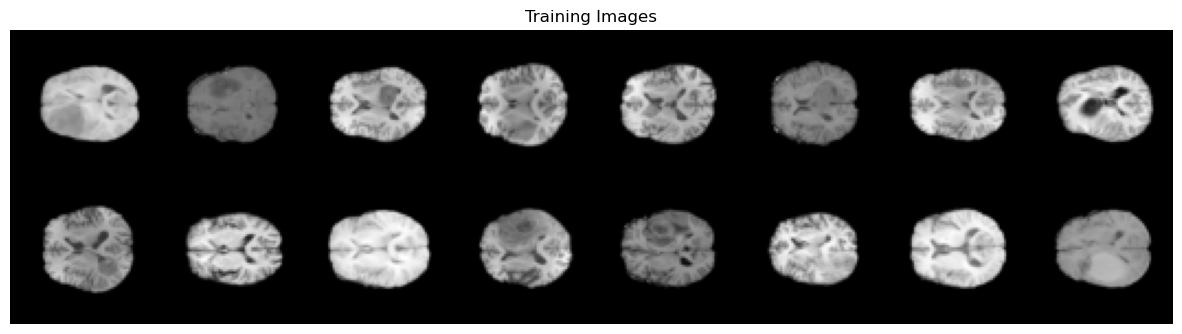

In [8]:
# Plot some training images
print(real_batch.shape)
# Actually plot it
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch.to(device)[:16], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)

In [9]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [10]:
class Critic(nn.Module):
    def __init__(self, use_gp=False) -> None:
        super(Critic, self).__init__()
        if use_gp:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )
        else:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 2),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 4),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 8),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )
    
    def forward(self, input):
        return self.main(input)

In [11]:
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [12]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*16 x image_size/16 x image_size/16
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*8 x image_size/8 x image_size/8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*4 x image_size/4 x image_size/4
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*2 x image_size/2 x image_size/2
            nn.ConvTranspose2d(feature_map_size, 1, 4, 2, 1),
            nn.Tanh(),
            # output: 1 x image_size x image_size
        )
    
    def forward(self, input):
        return self.main(input)

In [13]:
generator_model = Generator().to(device)
generator_model.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [14]:
optimizer_generator = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training loop
print("Starting training....")
fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)
img_list = list()
d_loss_hist = list()
g_loss_hist = list()
psnr_hist = list()
ssim_hist = list()
best_psnr = -float("inf")
best_ssim = -float("inf")
best_g_weights = None
best_d_weights = None

print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        # Get batch of data
        real_batch = data.to(device)
        b_size = real_batch.shape[0]
        if b_size != batch_size:
            # drop last batch
            continue

        d_loss_vals = list()
        for _ in range(n_critic):
            # Train critic weight for real images
            critic_model.zero_grad()
            d_loss_real = critic_model(real_batch)

            # Update critic weight for fake images
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            fake_batch = generator_model(noise)
            d_loss_fake = critic_model(fake_batch)

            d_loss = -torch.mean(d_loss_real - d_loss_fake)
            if use_gp:
                # Random weight term for interpolation
                alpha = torch.rand(b_size, 1, 1, 1).to(device)
                # Get random interpolations between real and fake
                interpolates = torch.autograd.Variable(alpha * real_batch + (1 - alpha) * fake_batch, requires_grad=True).to(device)
                d_interpolates = critic_model(interpolates)
                fake = torch.autograd.Variable(torch.Tensor(d_interpolates.size()).fill_(1.0), requires_grad=False).to(device)
                # Get gradient w.r.t interpolates
                gradients = torch.autograd.grad(
                    outputs=d_interpolates,
                    inputs=interpolates,
                    grad_outputs=fake,
                    create_graph=True,
                )[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss += lambda_gp * gradient_penalty
            d_loss_vals.append(d_loss.detach().cpu().numpy())
            d_loss.backward()
            optimizer_critic.step()

            if use_gp:
                # no op
                ...
            else:
                # Clamp critic weights
                for p in critic_model.parameters():
                    p.data.clamp_(-clipping_param, clipping_param)
        
        d_loss_hist.append(np.mean(d_loss_vals))

        # Update generator weight
        generator_model.zero_grad()
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake_batch = generator_model(noise)
        output = critic_model(fake_batch)
        g_loss = -torch.mean(output)
        g_loss_hist.append(g_loss.detach().cpu().numpy())
        g_loss.backward()
        optimizer_generator.step()

        # Save best model based on PSNR every iteration
        psnr_hist.append(
            compute_psnr(
                real_batch.detach().cpu().numpy(),
                fake_batch.detach().cpu().numpy()
            )
        )
        ssim_hist.append(
            compute_ssim(
                real_batch.detach().cpu().numpy(),
                fake_batch.detach().cpu().numpy()
            )
        )
        if psnr_hist[-1] > best_psnr:
            best_psnr = psnr_hist[-1]
            best_ssim = ssim_hist[-1]
            best_g_weights = generator_model.state_dict()
            best_d_weights = critic_model.state_dict()

    tqdm.write("\n".join((
        f"epoch: {epoch}, d_loss: {d_loss_hist[-1]:.4f}, g_loss: {g_loss_hist[-1]:.4f} ",
        f"psnr: {psnr_hist[-1]:.4f}, best_psnr: {best_psnr:.4f} ",
        f"ssim: {ssim_hist[-1]:.4f}, best_ssim: {best_ssim:.4f} ",
    )))

    # Check how the generator is doing by saving G's output on fixed_noise
    # with torch.no_grad():
    #     fake = generator_model(fixed_noise).detach().cpu()
    # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting training....
Number of mini batch iterations per epoch: 12


12it [00:07,  1.63it/s]

epoch: 0, d_loss: -3949.0891, g_loss: 55818.7031 
psnr: 11.4849, best_psnr: 11.4849 
ssim: 0.0999, best_ssim: 0.0999 



12it [00:06,  1.89it/s]

epoch: 1, d_loss: -2528.2170, g_loss: 86509.5391 
psnr: 13.6957, best_psnr: 13.9620 
ssim: 0.1510, best_ssim: 0.1586 



12it [00:06,  1.91it/s]

epoch: 2, d_loss: -1201.8529, g_loss: 69253.8750 
psnr: 15.5571, best_psnr: 15.5571 
ssim: 0.2096, best_ssim: 0.2096 



12it [00:06,  1.88it/s]

epoch: 3, d_loss: -922.8390, g_loss: 70224.2109 
psnr: 15.8677, best_psnr: 16.2358 
ssim: 0.2294, best_ssim: 0.1886 



12it [00:06,  1.98it/s]

epoch: 4, d_loss: -505.0686, g_loss: 75185.1328 
psnr: 16.8183, best_psnr: 17.1951 
ssim: 0.2606, best_ssim: 0.2859 



12it [00:05,  2.01it/s]

epoch: 5, d_loss: -517.9940, g_loss: 66293.0312 
psnr: 17.0189, best_psnr: 17.4513 
ssim: 0.2303, best_ssim: 0.3180 



12it [00:06,  1.94it/s]

epoch: 6, d_loss: -599.2051, g_loss: 73130.6719 
psnr: 17.2506, best_psnr: 17.5944 
ssim: 0.3304, best_ssim: 0.3033 



12it [00:06,  1.91it/s]

epoch: 7, d_loss: -793.8190, g_loss: 61420.6016 
psnr: 16.4374, best_psnr: 17.5944 
ssim: 0.3031, best_ssim: 0.3033 



12it [00:05,  2.04it/s]

epoch: 8, d_loss: -465.7184, g_loss: 59022.7539 
psnr: 16.5788, best_psnr: 17.5944 
ssim: 0.3730, best_ssim: 0.3033 



12it [00:06,  1.97it/s]

epoch: 9, d_loss: -1037.9446, g_loss: 69422.0391 
psnr: 16.7103, best_psnr: 17.5944 
ssim: 0.2155, best_ssim: 0.3033 



12it [00:06,  1.94it/s]

epoch: 10, d_loss: -392.3471, g_loss: 54342.7734 
psnr: 17.2112, best_psnr: 17.5944 
ssim: 0.3538, best_ssim: 0.3033 



12it [00:06,  1.98it/s]

epoch: 11, d_loss: -205.0374, g_loss: 45297.9531 
psnr: 17.8250, best_psnr: 18.2035 
ssim: 0.4644, best_ssim: 0.4301 



12it [00:06,  1.97it/s]

epoch: 12, d_loss: -453.7223, g_loss: 42426.2227 
psnr: 17.3646, best_psnr: 18.2035 
ssim: 0.2498, best_ssim: 0.4301 



12it [00:05,  2.01it/s]

epoch: 13, d_loss: -499.4187, g_loss: 34167.3555 
psnr: 16.1852, best_psnr: 18.2035 
ssim: 0.3170, best_ssim: 0.4301 



12it [00:05,  2.02it/s]

epoch: 14, d_loss: -517.3321, g_loss: 26671.5820 
psnr: 17.6398, best_psnr: 18.3087 
ssim: 0.2881, best_ssim: 0.5113 



12it [00:06,  1.99it/s]

epoch: 15, d_loss: -630.9379, g_loss: 13836.8994 
psnr: 15.4416, best_psnr: 18.3087 
ssim: 0.3769, best_ssim: 0.5113 



12it [00:06,  1.97it/s]

epoch: 16, d_loss: -137.4513, g_loss: 26637.8633 
psnr: 17.6151, best_psnr: 18.3087 
ssim: 0.4150, best_ssim: 0.5113 



12it [00:06,  1.98it/s]

epoch: 17, d_loss: -599.9261, g_loss: 28924.7832 
psnr: 16.8106, best_psnr: 18.3087 
ssim: 0.3853, best_ssim: 0.5113 



12it [00:05,  2.05it/s]

epoch: 18, d_loss: -41.2321, g_loss: 24993.2676 
psnr: 16.7871, best_psnr: 18.3087 
ssim: 0.4775, best_ssim: 0.5113 



12it [00:05,  2.00it/s]

epoch: 19, d_loss: -332.6175, g_loss: 26628.4648 
psnr: 16.7625, best_psnr: 18.3087 
ssim: 0.3747, best_ssim: 0.5113 



12it [00:06,  1.97it/s]

epoch: 20, d_loss: -387.7256, g_loss: 28018.2656 
psnr: 17.0248, best_psnr: 18.3087 
ssim: 0.4486, best_ssim: 0.5113 



12it [00:05,  2.05it/s]

epoch: 21, d_loss: -96.1533, g_loss: 12996.6035 
psnr: 17.4893, best_psnr: 18.3087 
ssim: 0.5046, best_ssim: 0.5113 



12it [00:05,  2.04it/s]

epoch: 22, d_loss: -83.7766, g_loss: 10424.9688 
psnr: 17.6020, best_psnr: 18.3087 
ssim: 0.5778, best_ssim: 0.5113 



12it [00:06,  2.00it/s]

epoch: 23, d_loss: 203.8318, g_loss: 16515.1035 
psnr: 18.1398, best_psnr: 18.4797 
ssim: 0.5901, best_ssim: 0.5124 



12it [00:05,  2.03it/s]

epoch: 24, d_loss: -106.0188, g_loss: 16456.7598 
psnr: 18.0154, best_psnr: 18.5378 
ssim: 0.5120, best_ssim: 0.4332 



12it [00:05,  2.03it/s]

epoch: 25, d_loss: 31.3603, g_loss: 3424.7559 
psnr: 15.9687, best_psnr: 18.7103 
ssim: 0.4572, best_ssim: 0.5597 



12it [00:06,  1.98it/s]

epoch: 26, d_loss: -103.7053, g_loss: 17270.1992 
psnr: 18.1127, best_psnr: 18.7103 
ssim: 0.5687, best_ssim: 0.5597 



12it [00:05,  2.02it/s]

epoch: 27, d_loss: -270.4185, g_loss: 17201.9570 
psnr: 18.7875, best_psnr: 18.9393 
ssim: 0.4271, best_ssim: 0.5007 



12it [00:06,  1.99it/s]

epoch: 28, d_loss: -74.5134, g_loss: 4456.3350 
psnr: 17.8118, best_psnr: 19.2210 
ssim: 0.4381, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 29, d_loss: -79.8228, g_loss: 6883.9990 
psnr: 16.8845, best_psnr: 19.2210 
ssim: 0.4768, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 30, d_loss: -175.2514, g_loss: 21347.5508 
psnr: 17.6665, best_psnr: 19.2210 
ssim: 0.4393, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 31, d_loss: 130.7662, g_loss: 14198.9961 
psnr: 17.8706, best_psnr: 19.2210 
ssim: 0.5528, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 32, d_loss: 98.4118, g_loss: 14691.6309 
psnr: 18.0766, best_psnr: 19.2210 
ssim: 0.5242, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 33, d_loss: -232.8415, g_loss: 14555.4131 
psnr: 17.1278, best_psnr: 19.2210 
ssim: 0.4108, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 34, d_loss: -215.8488, g_loss: 17046.9766 
psnr: 18.5109, best_psnr: 19.2210 
ssim: 0.5719, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 35, d_loss: -311.2744, g_loss: 10651.5166 
psnr: 17.5638, best_psnr: 19.2210 
ssim: 0.5248, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 36, d_loss: 65.7241, g_loss: 13931.6758 
psnr: 16.9190, best_psnr: 19.2210 
ssim: 0.5188, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 37, d_loss: -59.9731, g_loss: 18891.6016 
psnr: 17.4476, best_psnr: 19.2210 
ssim: 0.5779, best_ssim: 0.5949 



12it [00:07,  1.71it/s]

epoch: 38, d_loss: -141.3089, g_loss: 20511.2793 
psnr: 17.6894, best_psnr: 19.2210 
ssim: 0.4375, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 39, d_loss: -2.7724, g_loss: 11612.0547 
psnr: 17.7032, best_psnr: 19.2210 
ssim: 0.5191, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 40, d_loss: -149.2963, g_loss: 19361.9316 
psnr: 18.3004, best_psnr: 19.2210 
ssim: 0.6138, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 41, d_loss: -371.5880, g_loss: 1056.7563 
psnr: 17.5816, best_psnr: 19.2210 
ssim: 0.5437, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 42, d_loss: -517.4672, g_loss: 31687.4219 
psnr: 17.8780, best_psnr: 19.2210 
ssim: 0.3420, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 43, d_loss: -616.0373, g_loss: 30833.0605 
psnr: 16.7530, best_psnr: 19.2210 
ssim: 0.4497, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 44, d_loss: -236.6562, g_loss: 23138.7812 
psnr: 17.6056, best_psnr: 19.2210 
ssim: 0.4263, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 45, d_loss: -90.9596, g_loss: 4019.5901 
psnr: 18.2735, best_psnr: 19.2210 
ssim: 0.4862, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 46, d_loss: -104.5769, g_loss: 9479.8301 
psnr: 18.8964, best_psnr: 19.2210 
ssim: 0.6305, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 47, d_loss: -327.0672, g_loss: 13261.5918 
psnr: 18.1206, best_psnr: 19.2210 
ssim: 0.3496, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 48, d_loss: -167.5200, g_loss: 16681.6289 
psnr: 17.5507, best_psnr: 19.2210 
ssim: 0.4992, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 49, d_loss: -24.5963, g_loss: 1165.0864 
psnr: 17.7431, best_psnr: 19.2210 
ssim: 0.4313, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 50, d_loss: -128.6957, g_loss: 16215.9648 
psnr: 17.5459, best_psnr: 19.2210 
ssim: 0.4448, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 51, d_loss: -100.8751, g_loss: 10554.2822 
psnr: 18.5708, best_psnr: 19.2210 
ssim: 0.4695, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 52, d_loss: -567.4653, g_loss: 23914.6035 
psnr: 17.6539, best_psnr: 19.2210 
ssim: 0.5393, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 53, d_loss: 599.4077, g_loss: 3830.7837 
psnr: 17.0851, best_psnr: 19.2210 
ssim: 0.4896, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 54, d_loss: -234.9402, g_loss: 6069.2788 
psnr: 17.2475, best_psnr: 19.2210 
ssim: 0.4611, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 55, d_loss: -71.6038, g_loss: 10853.0000 
psnr: 17.6606, best_psnr: 19.2210 
ssim: 0.5716, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 56, d_loss: 85.0606, g_loss: 9461.6543 
psnr: 18.4212, best_psnr: 19.2210 
ssim: 0.4039, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 57, d_loss: -268.9446, g_loss: -262.8722 
psnr: 18.1499, best_psnr: 19.2210 
ssim: 0.4047, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 58, d_loss: -183.3272, g_loss: 21074.0234 
psnr: 18.0882, best_psnr: 19.2210 
ssim: 0.5847, best_ssim: 0.5949 



12it [00:06,  1.76it/s]

epoch: 59, d_loss: -62.1925, g_loss: 2263.5417 
psnr: 18.0998, best_psnr: 19.2210 
ssim: 0.4560, best_ssim: 0.5949 



12it [00:06,  1.75it/s]

epoch: 60, d_loss: -265.8664, g_loss: 14230.2031 
psnr: 17.7849, best_psnr: 19.2210 
ssim: 0.4773, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 61, d_loss: -461.6629, g_loss: -22720.9688 
psnr: 17.2436, best_psnr: 19.2210 
ssim: 0.2756, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 62, d_loss: -65.8088, g_loss: 2827.5347 
psnr: 17.5183, best_psnr: 19.2210 
ssim: 0.4734, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 63, d_loss: -78.5075, g_loss: 5818.2539 
psnr: 17.7141, best_psnr: 19.2210 
ssim: 0.5123, best_ssim: 0.5949 



12it [00:06,  1.81it/s]

epoch: 64, d_loss: -312.7136, g_loss: 16658.3594 
psnr: 18.4138, best_psnr: 19.2210 
ssim: 0.3999, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 65, d_loss: -211.4767, g_loss: 7410.7173 
psnr: 17.8913, best_psnr: 19.2210 
ssim: 0.4864, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 66, d_loss: -160.3943, g_loss: 14881.0693 
psnr: 18.0458, best_psnr: 19.2210 
ssim: 0.4664, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 67, d_loss: -60.8031, g_loss: 7889.6885 
psnr: 17.2090, best_psnr: 19.2210 
ssim: 0.4351, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 68, d_loss: -105.8660, g_loss: 10882.4824 
psnr: 17.7411, best_psnr: 19.2210 
ssim: 0.6017, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 69, d_loss: -114.8718, g_loss: 6710.9512 
psnr: 17.8016, best_psnr: 19.2210 
ssim: 0.4379, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 70, d_loss: -278.2818, g_loss: 10979.1104 
psnr: 17.3946, best_psnr: 19.2210 
ssim: 0.3973, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 71, d_loss: -132.8809, g_loss: 8088.4424 
psnr: 17.6236, best_psnr: 19.2210 
ssim: 0.6338, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 72, d_loss: -305.1179, g_loss: 11967.6514 
psnr: 17.2634, best_psnr: 19.2210 
ssim: 0.4852, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 73, d_loss: 10.3228, g_loss: 3915.0737 
psnr: 17.8203, best_psnr: 19.2210 
ssim: 0.4778, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 74, d_loss: -260.2176, g_loss: -6863.6338 
psnr: 17.7625, best_psnr: 19.2210 
ssim: 0.4846, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 75, d_loss: -488.9066, g_loss: -30457.8711 
psnr: 17.0331, best_psnr: 19.2210 
ssim: 0.3652, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 76, d_loss: -86.2602, g_loss: 10731.1426 
psnr: 17.4576, best_psnr: 19.2210 
ssim: 0.3930, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 77, d_loss: 38.3708, g_loss: 8933.9219 
psnr: 17.7616, best_psnr: 19.2210 
ssim: 0.3775, best_ssim: 0.5949 



12it [00:06,  1.84it/s]

epoch: 78, d_loss: -238.1271, g_loss: 14201.2676 
psnr: 17.3609, best_psnr: 19.2210 
ssim: 0.3534, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 79, d_loss: -219.7395, g_loss: 6046.1719 
psnr: 17.1540, best_psnr: 19.2210 
ssim: 0.4846, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 80, d_loss: -173.1558, g_loss: 5732.2070 
psnr: 18.4254, best_psnr: 19.2210 
ssim: 0.4847, best_ssim: 0.5949 



12it [00:06,  1.80it/s]

epoch: 81, d_loss: -147.8763, g_loss: 6884.6069 
psnr: 18.0401, best_psnr: 19.2210 
ssim: 0.3709, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 82, d_loss: -164.3205, g_loss: 11169.2598 
psnr: 17.9795, best_psnr: 19.2210 
ssim: 0.4271, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 83, d_loss: -64.3672, g_loss: 6159.9326 
psnr: 17.7471, best_psnr: 19.2210 
ssim: 0.4888, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 84, d_loss: -146.4242, g_loss: 7734.4951 
psnr: 17.3630, best_psnr: 19.2210 
ssim: 0.5459, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 85, d_loss: -56.1749, g_loss: 5978.3208 
psnr: 17.0811, best_psnr: 19.2210 
ssim: 0.4152, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 86, d_loss: -138.1480, g_loss: 641.6732 
psnr: 17.3883, best_psnr: 19.2210 
ssim: 0.5258, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 87, d_loss: -167.5552, g_loss: 5688.9058 
psnr: 17.6195, best_psnr: 19.2210 
ssim: 0.5649, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 88, d_loss: -253.9035, g_loss: 16730.4336 
psnr: 17.6703, best_psnr: 19.2210 
ssim: 0.5200, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 89, d_loss: 63.3160, g_loss: 7489.2334 
psnr: 17.1675, best_psnr: 19.2210 
ssim: 0.3550, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 90, d_loss: -219.8572, g_loss: -3192.9995 
psnr: 16.7459, best_psnr: 19.2210 
ssim: 0.5018, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 91, d_loss: -57.5733, g_loss: 2258.4612 
psnr: 17.8571, best_psnr: 19.2210 
ssim: 0.5674, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 92, d_loss: -96.1554, g_loss: 5764.5493 
psnr: 16.8668, best_psnr: 19.2210 
ssim: 0.5227, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 93, d_loss: -78.4650, g_loss: -8944.4746 
psnr: 17.4163, best_psnr: 19.2210 
ssim: 0.5566, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 94, d_loss: -146.3065, g_loss: -262.7791 
psnr: 17.8830, best_psnr: 19.2210 
ssim: 0.6194, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 95, d_loss: -130.1151, g_loss: 9398.6211 
psnr: 17.1708, best_psnr: 19.2210 
ssim: 0.5370, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 96, d_loss: -147.4416, g_loss: 3199.6733 
psnr: 17.1923, best_psnr: 19.2210 
ssim: 0.4634, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 97, d_loss: -159.0181, g_loss: 3186.1274 
psnr: 17.5381, best_psnr: 19.2210 
ssim: 0.4352, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 98, d_loss: -465.6547, g_loss: -14124.6914 
psnr: 16.5441, best_psnr: 19.2210 
ssim: 0.2514, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 99, d_loss: -131.3051, g_loss: -3824.3564 
psnr: 17.3231, best_psnr: 19.2210 
ssim: 0.6187, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 100, d_loss: -123.2746, g_loss: 3499.0381 
psnr: 18.0518, best_psnr: 19.2210 
ssim: 0.5773, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 101, d_loss: -77.1224, g_loss: 8321.5830 
psnr: 17.5557, best_psnr: 19.2210 
ssim: 0.6000, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 102, d_loss: -129.1522, g_loss: 1953.7676 
psnr: 17.7884, best_psnr: 19.2210 
ssim: 0.4707, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 103, d_loss: -147.9002, g_loss: 7983.3110 
psnr: 17.2695, best_psnr: 19.2210 
ssim: 0.4118, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 104, d_loss: -212.2903, g_loss: 2973.1260 
psnr: 16.8194, best_psnr: 19.2210 
ssim: 0.4220, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 105, d_loss: -125.7592, g_loss: -3167.4153 
psnr: 17.9632, best_psnr: 19.2210 
ssim: 0.6548, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 106, d_loss: 107.4852, g_loss: 3752.7939 
psnr: 17.7226, best_psnr: 19.2210 
ssim: 0.5605, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 107, d_loss: 76.0858, g_loss: 5843.0186 
psnr: 17.3703, best_psnr: 19.2210 
ssim: 0.5827, best_ssim: 0.5949 



12it [00:06,  1.84it/s]

epoch: 108, d_loss: 165.6263, g_loss: 2460.6216 
psnr: 17.3311, best_psnr: 19.2210 
ssim: 0.5006, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 109, d_loss: -205.6416, g_loss: 9311.5166 
psnr: 17.6835, best_psnr: 19.2210 
ssim: 0.4846, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 110, d_loss: -148.3911, g_loss: -677.1194 
psnr: 17.9454, best_psnr: 19.2210 
ssim: 0.6274, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 111, d_loss: -247.4007, g_loss: 19888.1973 
psnr: 17.5816, best_psnr: 19.2210 
ssim: 0.5040, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 112, d_loss: -249.8812, g_loss: 1820.3020 
psnr: 17.5860, best_psnr: 19.2210 
ssim: 0.6328, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 113, d_loss: -236.2132, g_loss: 12703.9756 
psnr: 17.7879, best_psnr: 19.2210 
ssim: 0.5344, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 114, d_loss: -103.6950, g_loss: 3124.3372 
psnr: 17.8273, best_psnr: 19.2210 
ssim: 0.5287, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 115, d_loss: -94.5970, g_loss: 2560.5906 
psnr: 18.1189, best_psnr: 19.2210 
ssim: 0.4830, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 116, d_loss: -2.2139, g_loss: 13286.7910 
psnr: 17.7720, best_psnr: 19.2210 
ssim: 0.6395, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 117, d_loss: -71.1630, g_loss: 3509.7952 
psnr: 18.2966, best_psnr: 19.2210 
ssim: 0.5117, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 118, d_loss: -136.8069, g_loss: -5268.2085 
psnr: 18.0965, best_psnr: 19.2210 
ssim: 0.6184, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 119, d_loss: -22.1557, g_loss: 4734.2646 
psnr: 18.4511, best_psnr: 19.2210 
ssim: 0.6053, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 120, d_loss: -151.0437, g_loss: -4648.1738 
psnr: 17.5767, best_psnr: 19.2210 
ssim: 0.4873, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 121, d_loss: -27.9139, g_loss: -927.0248 
psnr: 17.8089, best_psnr: 19.2210 
ssim: 0.5870, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 122, d_loss: -122.0861, g_loss: 4881.1484 
psnr: 18.0253, best_psnr: 19.2210 
ssim: 0.6199, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 123, d_loss: 211.6546, g_loss: 2417.4902 
psnr: 17.0052, best_psnr: 19.2210 
ssim: 0.3607, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 124, d_loss: -116.4720, g_loss: -2557.8921 
psnr: 17.7894, best_psnr: 19.2210 
ssim: 0.6185, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 125, d_loss: 222.6081, g_loss: -7623.1411 
psnr: 17.5963, best_psnr: 19.2210 
ssim: 0.4966, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 126, d_loss: -267.9632, g_loss: -23573.4414 
psnr: 17.5801, best_psnr: 19.2210 
ssim: 0.6419, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 127, d_loss: -126.9541, g_loss: -3060.6411 
psnr: 17.2246, best_psnr: 19.2210 
ssim: 0.5947, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 128, d_loss: -72.7214, g_loss: -147.6217 
psnr: 17.2326, best_psnr: 19.2210 
ssim: 0.4594, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 129, d_loss: 24.4515, g_loss: 3066.5356 
psnr: 18.1219, best_psnr: 19.2210 
ssim: 0.5122, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 130, d_loss: -213.0852, g_loss: 12373.7500 
psnr: 17.8076, best_psnr: 19.2210 
ssim: 0.3625, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 131, d_loss: -87.8533, g_loss: -1467.9136 
psnr: 17.8484, best_psnr: 19.2210 
ssim: 0.6076, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 132, d_loss: -160.9673, g_loss: -5447.3271 
psnr: 17.5763, best_psnr: 19.2210 
ssim: 0.5736, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 133, d_loss: -86.2401, g_loss: 2509.4490 
psnr: 17.2616, best_psnr: 19.2210 
ssim: 0.5708, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 134, d_loss: -81.2588, g_loss: 7301.6899 
psnr: 18.0333, best_psnr: 19.2210 
ssim: 0.6481, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 135, d_loss: -187.1889, g_loss: -7301.8184 
psnr: 18.0142, best_psnr: 19.2210 
ssim: 0.6437, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 136, d_loss: -180.2490, g_loss: 14433.0684 
psnr: 17.6479, best_psnr: 19.2210 
ssim: 0.5563, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 137, d_loss: -105.7931, g_loss: 6121.6772 
psnr: 16.9441, best_psnr: 19.2210 
ssim: 0.4683, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 138, d_loss: 170.9997, g_loss: -253.8960 
psnr: 17.3335, best_psnr: 19.2210 
ssim: 0.6033, best_ssim: 0.5949 



12it [00:06,  1.83it/s]

epoch: 139, d_loss: -144.4400, g_loss: -986.4905 
psnr: 16.8320, best_psnr: 19.2210 
ssim: 0.5950, best_ssim: 0.5949 



12it [00:06,  1.84it/s]

epoch: 140, d_loss: 343.6097, g_loss: 2400.2852 
psnr: 17.1431, best_psnr: 19.2210 
ssim: 0.6207, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 141, d_loss: -327.8766, g_loss: -21061.3828 
psnr: 16.9307, best_psnr: 19.2210 
ssim: 0.3905, best_ssim: 0.5949 



12it [00:06,  1.82it/s]

epoch: 142, d_loss: -188.3475, g_loss: -1312.0439 
psnr: 17.3481, best_psnr: 19.2210 
ssim: 0.3090, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 143, d_loss: -28.5559, g_loss: -3075.3369 
psnr: 18.2012, best_psnr: 19.2210 
ssim: 0.5262, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 144, d_loss: -216.4053, g_loss: 29956.1797 
psnr: 17.2503, best_psnr: 19.2210 
ssim: 0.4766, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 145, d_loss: -86.2931, g_loss: -3170.0620 
psnr: 17.2176, best_psnr: 19.2210 
ssim: 0.5890, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 146, d_loss: -183.4762, g_loss: 10077.0312 
psnr: 17.1035, best_psnr: 19.2210 
ssim: 0.5806, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 147, d_loss: -401.3090, g_loss: -17311.8027 
psnr: 17.0700, best_psnr: 19.2210 
ssim: 0.4818, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 148, d_loss: 49.9971, g_loss: -6868.6260 
psnr: 17.5431, best_psnr: 19.2210 
ssim: 0.4212, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 149, d_loss: -62.0139, g_loss: -3041.0039 
psnr: 17.1540, best_psnr: 19.2210 
ssim: 0.6125, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 150, d_loss: -107.0780, g_loss: -2294.1750 
psnr: 17.6221, best_psnr: 19.2210 
ssim: 0.3538, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 151, d_loss: -466.4317, g_loss: -5411.0479 
psnr: 17.6628, best_psnr: 19.2210 
ssim: 0.3991, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 152, d_loss: -151.8929, g_loss: -6599.9561 
psnr: 17.6170, best_psnr: 19.2210 
ssim: 0.5973, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 153, d_loss: -109.3906, g_loss: 7447.4102 
psnr: 17.7603, best_psnr: 19.2210 
ssim: 0.6421, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 154, d_loss: -132.5337, g_loss: -660.7706 
psnr: 17.1857, best_psnr: 19.2210 
ssim: 0.5544, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 155, d_loss: -36.9129, g_loss: 1282.4634 
psnr: 17.4754, best_psnr: 19.2210 
ssim: 0.5531, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 156, d_loss: -109.2991, g_loss: -1903.0001 
psnr: 17.6638, best_psnr: 19.2210 
ssim: 0.6451, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 157, d_loss: -142.0449, g_loss: 1360.5186 
psnr: 18.2548, best_psnr: 19.2210 
ssim: 0.5870, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 158, d_loss: 79.9942, g_loss: 9806.5000 
psnr: 18.4230, best_psnr: 19.2210 
ssim: 0.6616, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 159, d_loss: -130.3075, g_loss: -16831.4277 
psnr: 17.2702, best_psnr: 19.2210 
ssim: 0.4900, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 160, d_loss: -100.5053, g_loss: 1841.0176 
psnr: 17.0165, best_psnr: 19.2210 
ssim: 0.6077, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 161, d_loss: -31.8876, g_loss: -6768.3672 
psnr: 17.1483, best_psnr: 19.2210 
ssim: 0.4688, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 162, d_loss: -196.4464, g_loss: 27621.5039 
psnr: 17.6548, best_psnr: 19.2210 
ssim: 0.6375, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 163, d_loss: -672.0308, g_loss: -32341.1465 
psnr: 17.5054, best_psnr: 19.2210 
ssim: 0.5918, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 164, d_loss: -38.7961, g_loss: 1587.0231 
psnr: 17.2519, best_psnr: 19.2210 
ssim: 0.5432, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 165, d_loss: 75.4734, g_loss: 194.5046 
psnr: 17.0804, best_psnr: 19.2210 
ssim: 0.6188, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 166, d_loss: 48.4848, g_loss: -3133.0103 
psnr: 17.7679, best_psnr: 19.2210 
ssim: 0.5912, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 167, d_loss: -97.2892, g_loss: -1093.4155 
psnr: 18.1431, best_psnr: 19.2210 
ssim: 0.6504, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 168, d_loss: 116.2865, g_loss: 6675.9243 
psnr: 18.0859, best_psnr: 19.2210 
ssim: 0.3646, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 169, d_loss: -161.1276, g_loss: 852.2218 
psnr: 18.3276, best_psnr: 19.2210 
ssim: 0.6132, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 170, d_loss: -69.5334, g_loss: 7706.9854 
psnr: 17.7539, best_psnr: 19.2210 
ssim: 0.6159, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 171, d_loss: -122.9482, g_loss: -9467.7441 
psnr: 17.1609, best_psnr: 19.2210 
ssim: 0.5799, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 172, d_loss: -41.1454, g_loss: 6696.7402 
psnr: 17.2818, best_psnr: 19.2210 
ssim: 0.5466, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 173, d_loss: -191.9334, g_loss: -9934.1504 
psnr: 17.6328, best_psnr: 19.2210 
ssim: 0.6481, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 174, d_loss: -94.0044, g_loss: -1526.0470 
psnr: 17.6372, best_psnr: 19.2210 
ssim: 0.6349, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 175, d_loss: -49.5872, g_loss: 2071.1636 
psnr: 17.5306, best_psnr: 19.2210 
ssim: 0.5337, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 176, d_loss: -73.5384, g_loss: -3584.5649 
psnr: 17.2075, best_psnr: 19.2210 
ssim: 0.4769, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 177, d_loss: -240.0569, g_loss: -14470.1484 
psnr: 17.6443, best_psnr: 19.2210 
ssim: 0.6507, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 178, d_loss: -643.8765, g_loss: -40303.2188 
psnr: 17.6340, best_psnr: 19.2210 
ssim: 0.3626, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 179, d_loss: -124.4276, g_loss: -132.5523 
psnr: 17.1133, best_psnr: 19.2210 
ssim: 0.5819, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 180, d_loss: -79.8057, g_loss: -140.0463 
psnr: 17.8755, best_psnr: 19.2210 
ssim: 0.5750, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 181, d_loss: -85.0688, g_loss: 11996.5078 
psnr: 17.0723, best_psnr: 19.2210 
ssim: 0.5957, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 182, d_loss: -31.2986, g_loss: -4987.5312 
psnr: 17.6420, best_psnr: 19.2210 
ssim: 0.4933, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 183, d_loss: -124.8073, g_loss: 15256.4512 
psnr: 17.0358, best_psnr: 19.2210 
ssim: 0.5513, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 184, d_loss: -54.0870, g_loss: -3999.3440 
psnr: 18.0682, best_psnr: 19.2210 
ssim: 0.6668, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 185, d_loss: -92.2488, g_loss: -16775.2266 
psnr: 17.4261, best_psnr: 19.2210 
ssim: 0.5365, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 186, d_loss: -65.7180, g_loss: 4339.1875 
psnr: 17.7030, best_psnr: 19.2210 
ssim: 0.5408, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 187, d_loss: -348.9375, g_loss: -9708.4199 
psnr: 17.6158, best_psnr: 19.2210 
ssim: 0.4721, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 188, d_loss: 82.0257, g_loss: -4029.0864 
psnr: 17.8031, best_psnr: 19.2210 
ssim: 0.6584, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 189, d_loss: -187.2737, g_loss: 6052.0474 
psnr: 18.0387, best_psnr: 19.2210 
ssim: 0.2694, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 190, d_loss: -181.3660, g_loss: 26358.3223 
psnr: 17.1645, best_psnr: 19.2210 
ssim: 0.5837, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 191, d_loss: 8.3329, g_loss: -5558.0137 
psnr: 18.0668, best_psnr: 19.2210 
ssim: 0.4643, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 192, d_loss: -107.8112, g_loss: 32577.9609 
psnr: 17.9738, best_psnr: 19.2210 
ssim: 0.6073, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 193, d_loss: -184.1106, g_loss: 1810.7563 
psnr: 17.2468, best_psnr: 19.2210 
ssim: 0.3723, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 194, d_loss: 53.8033, g_loss: 707.2678 
psnr: 17.5166, best_psnr: 19.2210 
ssim: 0.6035, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 195, d_loss: -94.6048, g_loss: -5692.7227 
psnr: 17.2884, best_psnr: 19.2210 
ssim: 0.6128, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 196, d_loss: -212.6884, g_loss: 20962.4844 
psnr: 17.3510, best_psnr: 19.2210 
ssim: 0.5943, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 197, d_loss: -55.7840, g_loss: -3842.9397 
psnr: 17.3212, best_psnr: 19.2210 
ssim: 0.6572, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 198, d_loss: -1.0504, g_loss: 4187.2451 
psnr: 17.8576, best_psnr: 19.2210 
ssim: 0.6084, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 199, d_loss: 160.7427, g_loss: -1303.5505 
psnr: 18.0129, best_psnr: 19.2210 
ssim: 0.5540, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 200, d_loss: -65.8483, g_loss: -20144.3789 
psnr: 17.0477, best_psnr: 19.2210 
ssim: 0.6192, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 201, d_loss: -56.0683, g_loss: 11146.3965 
psnr: 18.0402, best_psnr: 19.2210 
ssim: 0.6042, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 202, d_loss: -165.9762, g_loss: 3379.9690 
psnr: 17.0019, best_psnr: 19.2210 
ssim: 0.5994, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 203, d_loss: -419.5514, g_loss: 54484.3828 
psnr: 17.5973, best_psnr: 19.2210 
ssim: 0.5197, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 204, d_loss: -140.0200, g_loss: -10736.1152 
psnr: 17.4573, best_psnr: 19.2210 
ssim: 0.4146, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 205, d_loss: -72.1449, g_loss: 3918.8281 
psnr: 17.9679, best_psnr: 19.2210 
ssim: 0.6527, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 206, d_loss: 2.8495, g_loss: -3828.1416 
psnr: 17.7601, best_psnr: 19.2210 
ssim: 0.5221, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 207, d_loss: -56.2252, g_loss: 4747.9844 
psnr: 17.8005, best_psnr: 19.2210 
ssim: 0.4704, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 208, d_loss: 150.5647, g_loss: -3934.2524 
psnr: 17.2250, best_psnr: 19.2210 
ssim: 0.5496, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 209, d_loss: -9.9418, g_loss: -2302.4692 
psnr: 17.8371, best_psnr: 19.2210 
ssim: 0.6223, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 210, d_loss: -63.7684, g_loss: 6131.9253 
psnr: 17.4610, best_psnr: 19.2210 
ssim: 0.6305, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 211, d_loss: -82.8885, g_loss: 7031.3828 
psnr: 17.3583, best_psnr: 19.2210 
ssim: 0.5619, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 212, d_loss: -50.8883, g_loss: 3360.9575 
psnr: 17.4046, best_psnr: 19.2210 
ssim: 0.5311, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 213, d_loss: -43.5929, g_loss: 2347.6941 
psnr: 17.0464, best_psnr: 19.2210 
ssim: 0.5671, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 214, d_loss: -36.2493, g_loss: -15061.6934 
psnr: 17.2456, best_psnr: 19.2210 
ssim: 0.3345, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 215, d_loss: -91.3336, g_loss: 24217.2266 
psnr: 17.5005, best_psnr: 19.2210 
ssim: 0.5655, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 216, d_loss: -212.5467, g_loss: 6212.1338 
psnr: 17.4084, best_psnr: 19.2210 
ssim: 0.6021, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 217, d_loss: 124.5464, g_loss: 3917.9365 
psnr: 18.0677, best_psnr: 19.2210 
ssim: 0.6640, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 218, d_loss: -51.8617, g_loss: 3534.0610 
psnr: 17.3088, best_psnr: 19.2210 
ssim: 0.6600, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 219, d_loss: 18.1560, g_loss: 8004.9844 
psnr: 17.2300, best_psnr: 19.2210 
ssim: 0.5947, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 220, d_loss: -189.9758, g_loss: -19914.8750 
psnr: 17.3853, best_psnr: 19.2210 
ssim: 0.6324, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 221, d_loss: -103.4368, g_loss: -8312.6133 
psnr: 17.6178, best_psnr: 19.2210 
ssim: 0.6371, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 222, d_loss: -86.4031, g_loss: -900.7557 
psnr: 18.0075, best_psnr: 19.2210 
ssim: 0.6358, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 223, d_loss: -255.5776, g_loss: 22022.3633 
psnr: 17.2697, best_psnr: 19.2210 
ssim: 0.6334, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 224, d_loss: 80.9440, g_loss: -16410.2070 
psnr: 17.6689, best_psnr: 19.2210 
ssim: 0.3239, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 225, d_loss: -56.7155, g_loss: -9589.6465 
psnr: 17.9267, best_psnr: 19.2210 
ssim: 0.5400, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 226, d_loss: -85.7149, g_loss: -8591.4199 
psnr: 17.4744, best_psnr: 19.2210 
ssim: 0.6112, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 227, d_loss: -24.0162, g_loss: 1184.2634 
psnr: 17.8391, best_psnr: 19.2210 
ssim: 0.6211, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 228, d_loss: 252.9966, g_loss: 9367.1328 
psnr: 17.9051, best_psnr: 19.2210 
ssim: 0.6230, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 229, d_loss: -146.8699, g_loss: 20496.8164 
psnr: 17.8086, best_psnr: 19.2210 
ssim: 0.6497, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 230, d_loss: -82.1891, g_loss: -8284.8848 
psnr: 17.6645, best_psnr: 19.2210 
ssim: 0.6447, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 231, d_loss: -39.2908, g_loss: 3409.6177 
psnr: 17.2830, best_psnr: 19.2210 
ssim: 0.6464, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 232, d_loss: -44.7072, g_loss: -1281.3701 
psnr: 17.6107, best_psnr: 19.2210 
ssim: 0.6167, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 233, d_loss: -23.4308, g_loss: 8825.5488 
psnr: 17.9145, best_psnr: 19.2210 
ssim: 0.6460, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 234, d_loss: -38.1238, g_loss: 7563.7720 
psnr: 16.4649, best_psnr: 19.2210 
ssim: 0.5899, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 235, d_loss: -353.3356, g_loss: -18277.7969 
psnr: 17.1053, best_psnr: 19.2210 
ssim: 0.5595, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 236, d_loss: -251.5305, g_loss: 38662.6328 
psnr: 17.2640, best_psnr: 19.2210 
ssim: 0.4884, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 237, d_loss: -44.1165, g_loss: -4344.8457 
psnr: 17.6945, best_psnr: 19.2210 
ssim: 0.4573, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 238, d_loss: -97.4625, g_loss: 4395.6221 
psnr: 17.9521, best_psnr: 19.2210 
ssim: 0.5171, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 239, d_loss: -32.2952, g_loss: -15363.5518 
psnr: 17.4630, best_psnr: 19.2210 
ssim: 0.6617, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 240, d_loss: 124.1353, g_loss: -7254.0156 
psnr: 17.5569, best_psnr: 19.2210 
ssim: 0.6512, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 241, d_loss: -42.5142, g_loss: -402.9538 
psnr: 17.9914, best_psnr: 19.2210 
ssim: 0.6194, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 242, d_loss: -76.7877, g_loss: -909.4322 
psnr: 18.0817, best_psnr: 19.2210 
ssim: 0.6532, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 243, d_loss: -139.6256, g_loss: 16126.5469 
psnr: 17.6697, best_psnr: 19.2210 
ssim: 0.6524, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 244, d_loss: 110.4185, g_loss: 4774.0703 
psnr: 17.5943, best_psnr: 19.2210 
ssim: 0.5581, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 245, d_loss: -30.2050, g_loss: 1346.3660 
psnr: 17.1817, best_psnr: 19.2210 
ssim: 0.5589, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 246, d_loss: -77.8816, g_loss: 11508.4805 
psnr: 17.6928, best_psnr: 19.2210 
ssim: 0.6410, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 247, d_loss: -64.2164, g_loss: -2761.8101 
psnr: 18.2005, best_psnr: 19.2210 
ssim: 0.6581, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 248, d_loss: -74.4941, g_loss: -4765.1665 
psnr: 17.3843, best_psnr: 19.2210 
ssim: 0.6448, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 249, d_loss: -50.1393, g_loss: -727.2678 
psnr: 17.7433, best_psnr: 19.2210 
ssim: 0.6566, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 250, d_loss: -58.7493, g_loss: -21826.3047 
psnr: 17.6822, best_psnr: 19.2210 
ssim: 0.5542, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 251, d_loss: -88.7063, g_loss: -8215.6797 
psnr: 17.2086, best_psnr: 19.2210 
ssim: 0.6028, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 252, d_loss: -87.9063, g_loss: -9215.2637 
psnr: 17.3136, best_psnr: 19.2210 
ssim: 0.4883, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 253, d_loss: 40.7801, g_loss: -14030.5820 
psnr: 16.8175, best_psnr: 19.2210 
ssim: 0.5240, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 254, d_loss: -62.5232, g_loss: -3221.9780 
psnr: 17.1909, best_psnr: 19.2210 
ssim: 0.6276, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 255, d_loss: 33.5367, g_loss: 8479.7324 
psnr: 17.5800, best_psnr: 19.2210 
ssim: 0.4861, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 256, d_loss: -144.7642, g_loss: 8725.0615 
psnr: 17.6973, best_psnr: 19.2210 
ssim: 0.5478, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 257, d_loss: 118.8381, g_loss: -3406.2703 
psnr: 17.3545, best_psnr: 19.2210 
ssim: 0.5196, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 258, d_loss: -32.2883, g_loss: 3840.1052 
psnr: 17.4507, best_psnr: 19.2210 
ssim: 0.5556, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 259, d_loss: 29.0021, g_loss: -7129.8008 
psnr: 17.5043, best_psnr: 19.2210 
ssim: 0.6235, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 260, d_loss: 89.9228, g_loss: 1903.1144 
psnr: 17.2994, best_psnr: 19.2210 
ssim: 0.5583, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 261, d_loss: 6.7478, g_loss: -16364.9648 
psnr: 18.2729, best_psnr: 19.2210 
ssim: 0.6644, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 262, d_loss: -39.6732, g_loss: -7666.0186 
psnr: 18.1594, best_psnr: 19.2210 
ssim: 0.6557, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 263, d_loss: -133.3080, g_loss: 15048.3184 
psnr: 18.1923, best_psnr: 19.2210 
ssim: 0.6222, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 264, d_loss: -335.8872, g_loss: -27181.4844 
psnr: 16.9640, best_psnr: 19.2210 
ssim: 0.6512, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 265, d_loss: -11.0881, g_loss: -3910.9119 
psnr: 17.7978, best_psnr: 19.2210 
ssim: 0.5434, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 266, d_loss: 212.8975, g_loss: -6583.3701 
psnr: 17.4746, best_psnr: 19.2210 
ssim: 0.5042, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 267, d_loss: -29.6333, g_loss: -1419.1652 
psnr: 17.0737, best_psnr: 19.2210 
ssim: 0.6111, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 268, d_loss: -59.9984, g_loss: -6922.3521 
psnr: 17.7966, best_psnr: 19.2210 
ssim: 0.4567, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 269, d_loss: -435.4904, g_loss: -58342.4922 
psnr: 17.1711, best_psnr: 19.2210 
ssim: 0.6392, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 270, d_loss: 1.2849, g_loss: 2202.8745 
psnr: 17.6836, best_psnr: 19.2210 
ssim: 0.6648, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 271, d_loss: 75.8698, g_loss: 3255.9658 
psnr: 17.1940, best_psnr: 19.2210 
ssim: 0.6505, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 272, d_loss: 190.7046, g_loss: 2841.4048 
psnr: 17.4827, best_psnr: 19.2210 
ssim: 0.6503, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 273, d_loss: -179.2863, g_loss: 25845.4629 
psnr: 17.2209, best_psnr: 19.2210 
ssim: 0.5503, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 274, d_loss: -9.4072, g_loss: -6019.0977 
psnr: 17.4221, best_psnr: 19.2210 
ssim: 0.6326, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 275, d_loss: -11.3968, g_loss: 454.4415 
psnr: 17.8884, best_psnr: 19.2210 
ssim: 0.6675, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 276, d_loss: -8.9012, g_loss: -10938.2773 
psnr: 17.6242, best_psnr: 19.2210 
ssim: 0.6025, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 277, d_loss: -47.2214, g_loss: 10959.3076 
psnr: 17.2226, best_psnr: 19.2210 
ssim: 0.6148, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 278, d_loss: -135.7875, g_loss: -15904.9658 
psnr: 18.6466, best_psnr: 19.2210 
ssim: 0.5465, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 279, d_loss: -50.2119, g_loss: -10639.8105 
psnr: 17.3583, best_psnr: 19.2210 
ssim: 0.5388, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 280, d_loss: 151.1199, g_loss: 13076.1230 
psnr: 18.0576, best_psnr: 19.2210 
ssim: 0.5990, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 281, d_loss: -52.9741, g_loss: -725.5029 
psnr: 16.8464, best_psnr: 19.2210 
ssim: 0.6051, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 282, d_loss: -42.7837, g_loss: 14228.5156 
psnr: 18.5402, best_psnr: 19.2210 
ssim: 0.6370, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 283, d_loss: -265.4843, g_loss: -56166.8750 
psnr: 17.0238, best_psnr: 19.2210 
ssim: 0.6015, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 284, d_loss: 52.5393, g_loss: 3476.1001 
psnr: 17.1553, best_psnr: 19.2210 
ssim: 0.5230, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 285, d_loss: -432.1884, g_loss: 53596.7383 
psnr: 17.4304, best_psnr: 19.2210 
ssim: 0.6265, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 286, d_loss: -42.9785, g_loss: 3198.4668 
psnr: 17.2107, best_psnr: 19.2210 
ssim: 0.5954, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 287, d_loss: -94.6572, g_loss: 10092.1162 
psnr: 17.6610, best_psnr: 19.2210 
ssim: 0.5105, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 288, d_loss: -61.6606, g_loss: -2008.0405 
psnr: 17.6259, best_psnr: 19.2210 
ssim: 0.5681, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 289, d_loss: -61.5927, g_loss: -215.1273 
psnr: 18.6670, best_psnr: 19.2210 
ssim: 0.6789, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 290, d_loss: -49.4521, g_loss: -2479.1929 
psnr: 17.5668, best_psnr: 19.2210 
ssim: 0.6462, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 291, d_loss: -114.6408, g_loss: -31572.6758 
psnr: 17.9670, best_psnr: 19.2210 
ssim: 0.6492, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 292, d_loss: -81.1804, g_loss: -1722.2190 
psnr: 17.8147, best_psnr: 19.2210 
ssim: 0.6695, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 293, d_loss: -375.5923, g_loss: -3427.5842 
psnr: 16.7600, best_psnr: 19.2210 
ssim: 0.5337, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 294, d_loss: -108.8575, g_loss: 11582.1758 
psnr: 17.3011, best_psnr: 19.2210 
ssim: 0.5458, best_ssim: 0.5949 



12it [00:05,  2.10it/s]


epoch: 295, d_loss: -37.2134, g_loss: 15355.3477 
psnr: 17.0394, best_psnr: 19.2210 
ssim: 0.6495, best_ssim: 0.5949 


12it [00:05,  2.09it/s]

epoch: 296, d_loss: -73.5918, g_loss: 17185.9336 
psnr: 17.3660, best_psnr: 19.2210 
ssim: 0.6587, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 297, d_loss: -142.6231, g_loss: -9088.1445 
psnr: 17.9499, best_psnr: 19.2210 
ssim: 0.6381, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 298, d_loss: -99.3584, g_loss: 32697.0723 
psnr: 17.2376, best_psnr: 19.2210 
ssim: 0.6542, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 299, d_loss: -45.1676, g_loss: -17805.3594 
psnr: 17.2467, best_psnr: 19.2210 
ssim: 0.6184, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 300, d_loss: -63.8711, g_loss: 10598.4248 
psnr: 17.8344, best_psnr: 19.2210 
ssim: 0.6670, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 301, d_loss: -78.4567, g_loss: 2045.3275 
psnr: 17.5053, best_psnr: 19.2210 
ssim: 0.6607, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 302, d_loss: -38.9554, g_loss: 1148.8757 
psnr: 17.3514, best_psnr: 19.2210 
ssim: 0.6420, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 303, d_loss: -35.8073, g_loss: -9368.3838 
psnr: 17.7225, best_psnr: 19.2210 
ssim: 0.6175, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 304, d_loss: -54.8840, g_loss: 2375.4006 
psnr: 17.3900, best_psnr: 19.2210 
ssim: 0.6211, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 305, d_loss: -56.1882, g_loss: -5683.4434 
psnr: 17.2057, best_psnr: 19.2210 
ssim: 0.6446, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 306, d_loss: -61.2981, g_loss: -17947.7539 
psnr: 17.7467, best_psnr: 19.2210 
ssim: 0.5903, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 307, d_loss: -57.4721, g_loss: 2726.6326 
psnr: 17.7134, best_psnr: 19.2210 
ssim: 0.6212, best_ssim: 0.5949 



12it [00:05,  2.05it/s]


epoch: 308, d_loss: -3.5648, g_loss: -3039.1848 
psnr: 17.9773, best_psnr: 19.2210 
ssim: 0.6599, best_ssim: 0.5949 


12it [00:05,  2.08it/s]

epoch: 309, d_loss: -8.6683, g_loss: 3714.4727 
psnr: 17.4474, best_psnr: 19.2210 
ssim: 0.6056, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 310, d_loss: -74.7361, g_loss: 3737.5378 
psnr: 17.4433, best_psnr: 19.2210 
ssim: 0.6541, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 311, d_loss: -38.6970, g_loss: -8043.5806 
psnr: 17.9519, best_psnr: 19.2210 
ssim: 0.5571, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 312, d_loss: 13.7589, g_loss: -32491.2812 
psnr: 16.5535, best_psnr: 19.2210 
ssim: 0.4805, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 313, d_loss: -26.6204, g_loss: 3489.9502 
psnr: 17.9621, best_psnr: 19.2210 
ssim: 0.6671, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 314, d_loss: -200.1714, g_loss: -19501.7871 
psnr: 17.4474, best_psnr: 19.2210 
ssim: 0.6453, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 315, d_loss: -60.0635, g_loss: 8346.6875 
psnr: 17.7696, best_psnr: 19.2210 
ssim: 0.5537, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 316, d_loss: -52.5884, g_loss: -28210.9277 
psnr: 17.1773, best_psnr: 19.2210 
ssim: 0.6455, best_ssim: 0.5949 



12it [00:05,  2.04it/s]


epoch: 317, d_loss: -32.4540, g_loss: 12487.9082 
psnr: 17.2418, best_psnr: 19.2210 
ssim: 0.6336, best_ssim: 0.5949 


12it [00:05,  2.03it/s]


epoch: 318, d_loss: -42.5381, g_loss: -232.7547 
psnr: 17.8893, best_psnr: 19.2210 
ssim: 0.6189, best_ssim: 0.5949 


12it [00:05,  2.06it/s]

epoch: 319, d_loss: -10.8318, g_loss: 15111.4023 
psnr: 17.6928, best_psnr: 19.2210 
ssim: 0.6014, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 320, d_loss: 42.4070, g_loss: 21711.5273 
psnr: 17.3433, best_psnr: 19.2210 
ssim: 0.5809, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 321, d_loss: -254.1451, g_loss: -9586.6562 
psnr: 17.5226, best_psnr: 19.2210 
ssim: 0.5660, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 322, d_loss: -25.6720, g_loss: 23144.6445 
psnr: 18.2236, best_psnr: 19.2210 
ssim: 0.6743, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 323, d_loss: -5.6304, g_loss: 14269.3027 
psnr: 17.5999, best_psnr: 19.2210 
ssim: 0.6637, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 324, d_loss: -45.7116, g_loss: -2583.9961 
psnr: 17.5030, best_psnr: 19.2210 
ssim: 0.6089, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 325, d_loss: -23.0118, g_loss: -5533.1660 
psnr: 17.9126, best_psnr: 19.2210 
ssim: 0.6639, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 326, d_loss: 48.6927, g_loss: 14034.5801 
psnr: 17.3887, best_psnr: 19.2210 
ssim: 0.6505, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 327, d_loss: 14.5840, g_loss: -5726.8184 
psnr: 17.9647, best_psnr: 19.2210 
ssim: 0.6403, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 328, d_loss: -53.5455, g_loss: 1217.5647 
psnr: 17.9014, best_psnr: 19.2210 
ssim: 0.5963, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 329, d_loss: -3.7517, g_loss: -4307.8594 
psnr: 17.7897, best_psnr: 19.2210 
ssim: 0.6331, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 330, d_loss: -8.7853, g_loss: 5434.8193 
psnr: 17.7737, best_psnr: 19.2210 
ssim: 0.6852, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 331, d_loss: -27.5023, g_loss: -2769.2300 
psnr: 16.9651, best_psnr: 19.2210 
ssim: 0.6451, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 332, d_loss: -16.9283, g_loss: -8531.8613 
psnr: 17.5801, best_psnr: 19.2210 
ssim: 0.5933, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 333, d_loss: -241.5852, g_loss: 47053.2070 
psnr: 17.6625, best_psnr: 19.2210 
ssim: 0.4020, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 334, d_loss: -60.7050, g_loss: 700.1736 
psnr: 17.5498, best_psnr: 19.2210 
ssim: 0.6331, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 335, d_loss: 76.5661, g_loss: -856.4794 
psnr: 17.6613, best_psnr: 19.2210 
ssim: 0.6095, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 336, d_loss: -183.6622, g_loss: -45609.4609 
psnr: 17.8941, best_psnr: 19.2210 
ssim: 0.3542, best_ssim: 0.5949 



12it [00:05,  2.12it/s]

epoch: 337, d_loss: -543.0122, g_loss: 11597.8613 
psnr: 17.3191, best_psnr: 19.2210 
ssim: 0.5220, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 338, d_loss: -65.6536, g_loss: 2708.8206 
psnr: 17.9812, best_psnr: 19.2210 
ssim: 0.6151, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 339, d_loss: -326.8556, g_loss: 70036.5000 
psnr: 17.1292, best_psnr: 19.2210 
ssim: 0.5082, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 340, d_loss: -133.2774, g_loss: 1660.8104 
psnr: 17.6222, best_psnr: 19.2210 
ssim: 0.6512, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 341, d_loss: -137.3166, g_loss: -52821.3867 
psnr: 16.9606, best_psnr: 19.2210 
ssim: 0.6271, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 342, d_loss: 1.5269, g_loss: -10116.9072 
psnr: 17.6005, best_psnr: 19.2210 
ssim: 0.5991, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 343, d_loss: -173.8201, g_loss: 56393.8281 
psnr: 17.9856, best_psnr: 19.2210 
ssim: 0.6713, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 344, d_loss: -23.4034, g_loss: 11051.5264 
psnr: 17.8912, best_psnr: 19.2210 
ssim: 0.5321, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 345, d_loss: -43.5260, g_loss: -7943.0557 
psnr: 17.8880, best_psnr: 19.2210 
ssim: 0.5664, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 346, d_loss: 61.5738, g_loss: 16688.7969 
psnr: 18.0309, best_psnr: 19.2210 
ssim: 0.6010, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 347, d_loss: -44.0965, g_loss: 4017.8608 
psnr: 17.5077, best_psnr: 19.2210 
ssim: 0.6286, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 348, d_loss: -38.8200, g_loss: 8175.9136 
psnr: 17.3572, best_psnr: 19.2210 
ssim: 0.5878, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 349, d_loss: -28.6588, g_loss: -469.9641 
psnr: 17.3488, best_psnr: 19.2210 
ssim: 0.6100, best_ssim: 0.5949 



12it [00:05,  2.13it/s]


epoch: 350, d_loss: -28.7546, g_loss: 9329.1475 
psnr: 17.3793, best_psnr: 19.2210 
ssim: 0.6509, best_ssim: 0.5949 


12it [00:05,  2.06it/s]

epoch: 351, d_loss: -16.1346, g_loss: -12982.3887 
psnr: 18.0236, best_psnr: 19.2210 
ssim: 0.6770, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 352, d_loss: -63.1919, g_loss: 6544.7656 
psnr: 18.0304, best_psnr: 19.2210 
ssim: 0.6218, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 353, d_loss: -82.2256, g_loss: 15668.9824 
psnr: 17.3910, best_psnr: 19.2210 
ssim: 0.6518, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 354, d_loss: -238.9167, g_loss: 32726.1230 
psnr: 17.4889, best_psnr: 19.2210 
ssim: 0.3741, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 355, d_loss: -54.3173, g_loss: -30061.3984 
psnr: 16.9979, best_psnr: 19.2210 
ssim: 0.6388, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 356, d_loss: -421.6007, g_loss: 55856.3984 
psnr: 17.3383, best_psnr: 19.2210 
ssim: 0.6105, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 357, d_loss: -29.7668, g_loss: 5602.2021 
psnr: 17.4160, best_psnr: 19.2210 
ssim: 0.5225, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 358, d_loss: 5.0108, g_loss: 20402.8477 
psnr: 17.0278, best_psnr: 19.2210 
ssim: 0.6192, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 359, d_loss: 41.9650, g_loss: 1127.0834 
psnr: 17.6906, best_psnr: 19.2210 
ssim: 0.6530, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 360, d_loss: 34.2167, g_loss: 72967.1719 
psnr: 17.8078, best_psnr: 19.2210 
ssim: 0.6185, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 361, d_loss: -81.7721, g_loss: -21360.5742 
psnr: 16.7923, best_psnr: 19.2210 
ssim: 0.6099, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 362, d_loss: -343.3276, g_loss: 6320.9854 
psnr: 17.2370, best_psnr: 19.2210 
ssim: 0.6266, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 363, d_loss: -90.9518, g_loss: 9010.6328 
psnr: 16.8561, best_psnr: 19.2210 
ssim: 0.5997, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 364, d_loss: -64.7831, g_loss: -4391.3892 
psnr: 17.1468, best_psnr: 19.2210 
ssim: 0.6362, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 365, d_loss: 69.0578, g_loss: 7147.8066 
psnr: 18.0090, best_psnr: 19.2210 
ssim: 0.6522, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 366, d_loss: -61.6537, g_loss: 13393.6396 
psnr: 17.4437, best_psnr: 19.2210 
ssim: 0.6166, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 367, d_loss: -291.0434, g_loss: -29040.4336 
psnr: 18.2213, best_psnr: 19.2210 
ssim: 0.6867, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 368, d_loss: -37.5462, g_loss: -11813.7129 
psnr: 17.8243, best_psnr: 19.2210 
ssim: 0.6368, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 369, d_loss: -205.0462, g_loss: 1865.8879 
psnr: 17.3586, best_psnr: 19.2210 
ssim: 0.6139, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 370, d_loss: -31.0475, g_loss: 8490.5615 
psnr: 18.0810, best_psnr: 19.2210 
ssim: 0.6368, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 371, d_loss: -37.5358, g_loss: 8910.0225 
psnr: 17.6941, best_psnr: 19.2210 
ssim: 0.6639, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 372, d_loss: -81.4824, g_loss: 12548.7461 
psnr: 17.4948, best_psnr: 19.2210 
ssim: 0.6625, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 373, d_loss: -28.9163, g_loss: -8770.3652 
psnr: 17.9686, best_psnr: 19.2210 
ssim: 0.6193, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 374, d_loss: -109.2487, g_loss: 20096.5566 
psnr: 17.4215, best_psnr: 19.2210 
ssim: 0.6683, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 375, d_loss: -60.9263, g_loss: -608.2970 
psnr: 17.9502, best_psnr: 19.2210 
ssim: 0.6356, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 376, d_loss: -38.7555, g_loss: -7654.2002 
psnr: 17.9740, best_psnr: 19.2210 
ssim: 0.6320, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 377, d_loss: -51.4326, g_loss: -343.5547 
psnr: 17.4906, best_psnr: 19.2210 
ssim: 0.6403, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 378, d_loss: -27.0602, g_loss: 2800.4170 
psnr: 18.3796, best_psnr: 19.2210 
ssim: 0.6432, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 379, d_loss: -55.9526, g_loss: 583.4355 
psnr: 17.1384, best_psnr: 19.2210 
ssim: 0.5757, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 380, d_loss: -76.0144, g_loss: -28464.0859 
psnr: 17.3636, best_psnr: 19.2210 
ssim: 0.6653, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 381, d_loss: -100.0376, g_loss: 3897.0730 
psnr: 17.6754, best_psnr: 19.2210 
ssim: 0.6172, best_ssim: 0.5949 



12it [00:05,  2.12it/s]

epoch: 382, d_loss: -78.2822, g_loss: -25583.4023 
psnr: 17.4995, best_psnr: 19.2210 
ssim: 0.6315, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 383, d_loss: -35.9138, g_loss: -3557.1006 
psnr: 18.0562, best_psnr: 19.2210 
ssim: 0.6361, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 384, d_loss: -38.9967, g_loss: 3784.9761 
psnr: 18.4127, best_psnr: 19.2210 
ssim: 0.6881, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 385, d_loss: -23.5082, g_loss: 1179.2812 
psnr: 17.2380, best_psnr: 19.2210 
ssim: 0.6712, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 386, d_loss: -61.2339, g_loss: 9251.7803 
psnr: 17.7853, best_psnr: 19.2210 
ssim: 0.6289, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 387, d_loss: -197.1796, g_loss: -48077.7656 
psnr: 17.8249, best_psnr: 19.2210 
ssim: 0.6409, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 388, d_loss: -49.8601, g_loss: 11288.0723 
psnr: 17.3900, best_psnr: 19.2210 
ssim: 0.6517, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 389, d_loss: -61.4109, g_loss: 17916.6875 
psnr: 18.0220, best_psnr: 19.2210 
ssim: 0.6738, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 390, d_loss: 30.0970, g_loss: 5767.5591 
psnr: 17.0508, best_psnr: 19.2210 
ssim: 0.6538, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 391, d_loss: -150.9185, g_loss: -4529.0674 
psnr: 17.5659, best_psnr: 19.2210 
ssim: 0.6483, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 392, d_loss: -58.2846, g_loss: 5541.7939 
psnr: 17.4629, best_psnr: 19.2210 
ssim: 0.6173, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 393, d_loss: -49.2175, g_loss: 646.0461 
psnr: 17.3560, best_psnr: 19.2210 
ssim: 0.6566, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 394, d_loss: -19.4818, g_loss: -15994.5088 
psnr: 17.5809, best_psnr: 19.2210 
ssim: 0.6601, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 395, d_loss: -41.2558, g_loss: -1269.3286 
psnr: 17.6760, best_psnr: 19.2210 
ssim: 0.6102, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 396, d_loss: -149.4416, g_loss: -64491.4961 
psnr: 17.7890, best_psnr: 19.2210 
ssim: 0.6441, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 397, d_loss: -45.7477, g_loss: 16079.9912 
psnr: 17.3502, best_psnr: 19.2210 
ssim: 0.5338, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 398, d_loss: -22.7872, g_loss: -340.2724 
psnr: 17.6550, best_psnr: 19.2210 
ssim: 0.6656, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 399, d_loss: -394.4625, g_loss: 71279.7891 
psnr: 17.9081, best_psnr: 19.2210 
ssim: 0.6823, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 400, d_loss: -6.7172, g_loss: 816.6066 
psnr: 17.6447, best_psnr: 19.2210 
ssim: 0.6657, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 401, d_loss: -67.6818, g_loss: 21963.2832 
psnr: 17.3639, best_psnr: 19.2210 
ssim: 0.6560, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 402, d_loss: -40.1183, g_loss: -1773.4694 
psnr: 17.7053, best_psnr: 19.2210 
ssim: 0.6431, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 403, d_loss: -95.0593, g_loss: 18856.9160 
psnr: 17.4130, best_psnr: 19.2210 
ssim: 0.6514, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 404, d_loss: -27.7711, g_loss: 4883.4585 
psnr: 17.8790, best_psnr: 19.2210 
ssim: 0.6722, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 405, d_loss: -67.1674, g_loss: -2721.7317 
psnr: 17.7411, best_psnr: 19.2210 
ssim: 0.6675, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 406, d_loss: -16.6002, g_loss: -8219.2109 
psnr: 17.3055, best_psnr: 19.2210 
ssim: 0.6439, best_ssim: 0.5949 



12it [00:05,  2.06it/s]


epoch: 407, d_loss: -28.9362, g_loss: -4347.4941 
psnr: 17.4762, best_psnr: 19.2210 
ssim: 0.6629, best_ssim: 0.5949 


12it [00:05,  2.02it/s]

epoch: 408, d_loss: -14.2024, g_loss: -4639.6621 
psnr: 17.5232, best_psnr: 19.2210 
ssim: 0.4849, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 409, d_loss: -26.2483, g_loss: 9922.8848 
psnr: 17.5533, best_psnr: 19.2210 
ssim: 0.5892, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 410, d_loss: -142.5496, g_loss: 11338.8906 
psnr: 16.8081, best_psnr: 19.2210 
ssim: 0.6409, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 411, d_loss: -62.6437, g_loss: -454.0671 
psnr: 18.1547, best_psnr: 19.2210 
ssim: 0.6032, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 412, d_loss: -24.5477, g_loss: -17995.6387 
psnr: 17.5142, best_psnr: 19.2210 
ssim: 0.6459, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 413, d_loss: -1.3641, g_loss: -14510.7256 
psnr: 17.8451, best_psnr: 19.2210 
ssim: 0.6582, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 414, d_loss: -28.2808, g_loss: 15425.4062 
psnr: 17.6578, best_psnr: 19.2210 
ssim: 0.6684, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 415, d_loss: -288.5082, g_loss: -34570.6562 
psnr: 17.7914, best_psnr: 19.2210 
ssim: 0.5476, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 416, d_loss: 149.4117, g_loss: 18266.8301 
psnr: 17.7127, best_psnr: 19.2210 
ssim: 0.5735, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 417, d_loss: -31.6296, g_loss: -4242.0488 
psnr: 17.3344, best_psnr: 19.2210 
ssim: 0.6190, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 418, d_loss: -120.1356, g_loss: 22441.0234 
psnr: 17.2255, best_psnr: 19.2210 
ssim: 0.6519, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 419, d_loss: -72.0192, g_loss: -3578.1523 
psnr: 17.5281, best_psnr: 19.2210 
ssim: 0.6651, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 420, d_loss: -32.2359, g_loss: -8761.4453 
psnr: 16.9900, best_psnr: 19.2210 
ssim: 0.6403, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 421, d_loss: 39.5989, g_loss: 7929.8828 
psnr: 17.7740, best_psnr: 19.2210 
ssim: 0.6019, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 422, d_loss: -36.7602, g_loss: -4238.9697 
psnr: 17.4669, best_psnr: 19.2210 
ssim: 0.5590, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 423, d_loss: -7.4027, g_loss: 4265.9629 
psnr: 17.6380, best_psnr: 19.2210 
ssim: 0.6618, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 424, d_loss: -68.1967, g_loss: 18086.8242 
psnr: 17.3017, best_psnr: 19.2210 
ssim: 0.6585, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 425, d_loss: -11.7444, g_loss: 4133.9229 
psnr: 17.8188, best_psnr: 19.2210 
ssim: 0.6437, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 426, d_loss: -31.6510, g_loss: 6055.8291 
psnr: 17.8331, best_psnr: 19.2210 
ssim: 0.6797, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 427, d_loss: 13.7245, g_loss: -456.3925 
psnr: 17.5785, best_psnr: 19.2210 
ssim: 0.6392, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 428, d_loss: -13.4102, g_loss: 32593.7070 
psnr: 17.5743, best_psnr: 19.2210 
ssim: 0.6725, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 429, d_loss: -28.2138, g_loss: 3863.2134 
psnr: 17.8603, best_psnr: 19.2210 
ssim: 0.6300, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 430, d_loss: -37.3024, g_loss: 1770.7268 
psnr: 17.6866, best_psnr: 19.2210 
ssim: 0.6603, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 431, d_loss: -242.7867, g_loss: -37046.2969 
psnr: 17.3365, best_psnr: 19.2210 
ssim: 0.6244, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 432, d_loss: 144.4144, g_loss: 9045.5596 
psnr: 17.2697, best_psnr: 19.2210 
ssim: 0.4678, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 433, d_loss: -78.9023, g_loss: 23486.0547 
psnr: 17.8992, best_psnr: 19.2210 
ssim: 0.6601, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 434, d_loss: 46.6820, g_loss: 4543.3408 
psnr: 17.3818, best_psnr: 19.2210 
ssim: 0.6617, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 435, d_loss: -100.4669, g_loss: 24981.0625 
psnr: 18.1143, best_psnr: 19.2210 
ssim: 0.6562, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 436, d_loss: 143.8250, g_loss: -13956.1084 
psnr: 17.4849, best_psnr: 19.2210 
ssim: 0.4391, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 437, d_loss: -62.0262, g_loss: 18045.3965 
psnr: 17.7840, best_psnr: 19.2210 
ssim: 0.6187, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 438, d_loss: -272.3150, g_loss: 94499.4062 
psnr: 17.6226, best_psnr: 19.2210 
ssim: 0.6675, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 439, d_loss: -50.0615, g_loss: -14796.2109 
psnr: 17.7917, best_psnr: 19.2210 
ssim: 0.6659, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 440, d_loss: -61.1551, g_loss: 24500.9277 
psnr: 17.7225, best_psnr: 19.2210 
ssim: 0.6591, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 441, d_loss: -13.8851, g_loss: -33750.8828 
psnr: 16.9397, best_psnr: 19.2210 
ssim: 0.6470, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 442, d_loss: 57.5000, g_loss: -15652.4766 
psnr: 17.8690, best_psnr: 19.2210 
ssim: 0.5384, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 443, d_loss: -57.1824, g_loss: 30641.6953 
psnr: 17.6349, best_psnr: 19.2210 
ssim: 0.6647, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 444, d_loss: -37.5634, g_loss: 34133.7812 
psnr: 17.7250, best_psnr: 19.2210 
ssim: 0.6588, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 445, d_loss: -59.0156, g_loss: -19150.7168 
psnr: 18.0412, best_psnr: 19.2210 
ssim: 0.6548, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 446, d_loss: -154.2496, g_loss: 23413.9766 
psnr: 17.5995, best_psnr: 19.2210 
ssim: 0.6548, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 447, d_loss: -38.3301, g_loss: -1653.1859 
psnr: 17.3145, best_psnr: 19.2210 
ssim: 0.6466, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 448, d_loss: -28.7704, g_loss: 5381.5068 
psnr: 17.9539, best_psnr: 19.2210 
ssim: 0.5758, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 449, d_loss: 61.4766, g_loss: 21440.3125 
psnr: 17.1682, best_psnr: 19.2210 
ssim: 0.6205, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 450, d_loss: -75.5772, g_loss: -18995.2969 
psnr: 17.3638, best_psnr: 19.2210 
ssim: 0.6304, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 451, d_loss: -295.0563, g_loss: 1973.0522 
psnr: 16.5340, best_psnr: 19.2210 
ssim: 0.6298, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 452, d_loss: -31.6143, g_loss: 21389.6680 
psnr: 17.5934, best_psnr: 19.2210 
ssim: 0.6394, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 453, d_loss: 86.8969, g_loss: -13119.6230 
psnr: 17.3562, best_psnr: 19.2210 
ssim: 0.6457, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 454, d_loss: -59.4876, g_loss: 16629.0391 
psnr: 17.6309, best_psnr: 19.2210 
ssim: 0.6715, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 455, d_loss: -59.0058, g_loss: 6834.8452 
psnr: 17.1521, best_psnr: 19.2210 
ssim: 0.6368, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 456, d_loss: -255.1248, g_loss: 26596.5469 
psnr: 17.6689, best_psnr: 19.2210 
ssim: 0.6769, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 457, d_loss: 267.8006, g_loss: 9197.3281 
psnr: 17.2265, best_psnr: 19.2210 
ssim: 0.5619, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 458, d_loss: -3.7849, g_loss: -613.0818 
psnr: 17.6494, best_psnr: 19.2210 
ssim: 0.5387, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 459, d_loss: -8.1335, g_loss: 6700.2378 
psnr: 17.6728, best_psnr: 19.2210 
ssim: 0.6572, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 460, d_loss: -97.6115, g_loss: 61119.2695 
psnr: 18.1399, best_psnr: 19.2210 
ssim: 0.6902, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 461, d_loss: 6.7752, g_loss: -10794.8760 
psnr: 17.2717, best_psnr: 19.2210 
ssim: 0.6791, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 462, d_loss: -38.2870, g_loss: 11779.0977 
psnr: 17.2623, best_psnr: 19.2210 
ssim: 0.6165, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 463, d_loss: -229.7332, g_loss: -21654.0566 
psnr: 17.4486, best_psnr: 19.2210 
ssim: 0.6338, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 464, d_loss: -55.9414, g_loss: -11360.0664 
psnr: 18.0587, best_psnr: 19.2210 
ssim: 0.6759, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 465, d_loss: -16.4041, g_loss: 13258.8203 
psnr: 17.2237, best_psnr: 19.2210 
ssim: 0.6767, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 466, d_loss: -35.0462, g_loss: -6398.7959 
psnr: 18.2695, best_psnr: 19.2210 
ssim: 0.6607, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 467, d_loss: -22.1415, g_loss: -15784.9746 
psnr: 18.1296, best_psnr: 19.2210 
ssim: 0.6873, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 468, d_loss: 34.6223, g_loss: -12056.7207 
psnr: 17.8810, best_psnr: 19.2210 
ssim: 0.6378, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 469, d_loss: -55.1544, g_loss: -37469.5859 
psnr: 18.2028, best_psnr: 19.2210 
ssim: 0.6887, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 470, d_loss: 11.1576, g_loss: 2587.8037 
psnr: 17.8690, best_psnr: 19.2210 
ssim: 0.6690, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 471, d_loss: -44.6712, g_loss: -31662.9688 
psnr: 17.3242, best_psnr: 19.2210 
ssim: 0.6403, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 472, d_loss: 26.6948, g_loss: -12083.2129 
psnr: 18.0126, best_psnr: 19.2210 
ssim: 0.6683, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 473, d_loss: 5.0046, g_loss: -10191.4297 
psnr: 17.4291, best_psnr: 19.2210 
ssim: 0.6550, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 474, d_loss: 121.9716, g_loss: -8273.3369 
psnr: 17.8719, best_psnr: 19.2210 
ssim: 0.6699, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 475, d_loss: -138.9239, g_loss: 9485.3906 
psnr: 17.7115, best_psnr: 19.2210 
ssim: 0.6612, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 476, d_loss: -190.0292, g_loss: 39585.2109 
psnr: 16.7332, best_psnr: 19.2210 
ssim: 0.5303, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 477, d_loss: 6.9510, g_loss: -22137.2676 
psnr: 17.6810, best_psnr: 19.2210 
ssim: 0.6674, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 478, d_loss: -16.9071, g_loss: -4319.6797 
psnr: 17.7076, best_psnr: 19.2210 
ssim: 0.6783, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 479, d_loss: -8.1884, g_loss: 10067.2891 
psnr: 17.7266, best_psnr: 19.2210 
ssim: 0.6688, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 480, d_loss: -2.2484, g_loss: 17651.2266 
psnr: 18.0026, best_psnr: 19.2210 
ssim: 0.6320, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 481, d_loss: -41.3472, g_loss: -8750.6738 
psnr: 17.4176, best_psnr: 19.2210 
ssim: 0.6364, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 482, d_loss: -31.6749, g_loss: 13471.3164 
psnr: 17.0710, best_psnr: 19.2210 
ssim: 0.6018, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 483, d_loss: -184.8344, g_loss: -10781.8848 
psnr: 16.8821, best_psnr: 19.2210 
ssim: 0.6361, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 484, d_loss: -139.4753, g_loss: -20821.4336 
psnr: 17.8280, best_psnr: 19.2210 
ssim: 0.6571, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 485, d_loss: 0.4625, g_loss: 14464.0361 
psnr: 18.1650, best_psnr: 19.2210 
ssim: 0.6614, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 486, d_loss: 141.9523, g_loss: 22332.9492 
psnr: 17.3087, best_psnr: 19.2210 
ssim: 0.5314, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 487, d_loss: 124.6805, g_loss: 8433.7129 
psnr: 17.5684, best_psnr: 19.2210 
ssim: 0.6650, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 488, d_loss: -1.6535, g_loss: 10398.1562 
psnr: 17.4599, best_psnr: 19.2210 
ssim: 0.6664, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 489, d_loss: -59.9516, g_loss: 20020.1914 
psnr: 17.3695, best_psnr: 19.2210 
ssim: 0.6628, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 490, d_loss: -194.7016, g_loss: -43796.5547 
psnr: 17.9027, best_psnr: 19.2210 
ssim: 0.6865, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 491, d_loss: 52.0803, g_loss: -9599.1729 
psnr: 18.1233, best_psnr: 19.2210 
ssim: 0.3886, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 492, d_loss: -64.4907, g_loss: 5568.4600 
psnr: 17.8634, best_psnr: 19.2210 
ssim: 0.6601, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 493, d_loss: -31.8137, g_loss: -5177.4600 
psnr: 17.1310, best_psnr: 19.2210 
ssim: 0.6731, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 494, d_loss: -39.1317, g_loss: 2753.2642 
psnr: 17.7383, best_psnr: 19.2210 
ssim: 0.6713, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 495, d_loss: -65.3827, g_loss: 39544.4688 
psnr: 16.9486, best_psnr: 19.2210 
ssim: 0.6515, best_ssim: 0.5949 



12it [00:05,  2.12it/s]

epoch: 496, d_loss: -37.6485, g_loss: -9155.4268 
psnr: 17.2744, best_psnr: 19.2210 
ssim: 0.6242, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 497, d_loss: -99.7020, g_loss: -6334.3130 
psnr: 17.1680, best_psnr: 19.2210 
ssim: 0.6611, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 498, d_loss: 47.8144, g_loss: 4236.9434 
psnr: 17.7628, best_psnr: 19.2210 
ssim: 0.6736, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 499, d_loss: -20.2945, g_loss: -15758.7158 
psnr: 16.9994, best_psnr: 19.2210 
ssim: 0.6368, best_ssim: 0.5949 



12it [00:05,  2.13it/s]

epoch: 500, d_loss: -17.7971, g_loss: 23578.4375 
psnr: 17.8289, best_psnr: 19.2210 
ssim: 0.6814, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 501, d_loss: -81.8639, g_loss: -14113.1094 
psnr: 17.8730, best_psnr: 19.2210 
ssim: 0.6663, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 502, d_loss: -158.1208, g_loss: 7624.3340 
psnr: 17.8200, best_psnr: 19.2210 
ssim: 0.6514, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 503, d_loss: -54.0035, g_loss: -10121.6934 
psnr: 17.2950, best_psnr: 19.2210 
ssim: 0.6481, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 504, d_loss: -19.4413, g_loss: 444.8299 
psnr: 17.8628, best_psnr: 19.2210 
ssim: 0.5395, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 505, d_loss: -51.1859, g_loss: 12446.5000 
psnr: 17.1364, best_psnr: 19.2210 
ssim: 0.6694, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 506, d_loss: -50.5564, g_loss: 332.5640 
psnr: 17.7591, best_psnr: 19.2210 
ssim: 0.6322, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 507, d_loss: 5.3697, g_loss: -2765.9741 
psnr: 17.6948, best_psnr: 19.2210 
ssim: 0.6592, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 508, d_loss: -80.4872, g_loss: 16631.9180 
psnr: 17.9843, best_psnr: 19.2210 
ssim: 0.6889, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 509, d_loss: -87.5266, g_loss: -33774.3203 
psnr: 17.8568, best_psnr: 19.2210 
ssim: 0.6672, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 510, d_loss: -59.7345, g_loss: 45501.3242 
psnr: 18.1966, best_psnr: 19.2210 
ssim: 0.6898, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 511, d_loss: -41.3448, g_loss: 762.9777 
psnr: 17.3740, best_psnr: 19.2210 
ssim: 0.6546, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 512, d_loss: 25.0933, g_loss: 2818.7622 
psnr: 17.6292, best_psnr: 19.2210 
ssim: 0.5921, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 513, d_loss: -15.3775, g_loss: -8816.7402 
psnr: 17.5003, best_psnr: 19.2210 
ssim: 0.6654, best_ssim: 0.5949 



12it [00:05,  2.10it/s]

epoch: 514, d_loss: -479.2324, g_loss: -41905.8750 
psnr: 17.2627, best_psnr: 19.2210 
ssim: 0.5649, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 515, d_loss: -127.2173, g_loss: 101.0357 
psnr: 17.4101, best_psnr: 19.2210 
ssim: 0.5378, best_ssim: 0.5949 



12it [00:05,  2.12it/s]

epoch: 516, d_loss: -30.1146, g_loss: -7230.1807 
psnr: 17.8045, best_psnr: 19.2210 
ssim: 0.6551, best_ssim: 0.5949 



12it [00:05,  2.11it/s]

epoch: 517, d_loss: -15.6320, g_loss: -5996.1045 
psnr: 16.6374, best_psnr: 19.2210 
ssim: 0.6032, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 518, d_loss: -61.4170, g_loss: -12587.4043 
psnr: 17.7067, best_psnr: 19.2210 
ssim: 0.6729, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 519, d_loss: 5.7469, g_loss: -8513.3311 
psnr: 17.5566, best_psnr: 19.2210 
ssim: 0.6767, best_ssim: 0.5949 



12it [00:05,  2.13it/s]

epoch: 520, d_loss: 85.2785, g_loss: 2864.0459 
psnr: 18.0932, best_psnr: 19.2210 
ssim: 0.6816, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 521, d_loss: -29.3591, g_loss: -18479.2090 
psnr: 17.4316, best_psnr: 19.2210 
ssim: 0.6576, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 522, d_loss: -149.6534, g_loss: -11553.0977 
psnr: 17.7003, best_psnr: 19.2210 
ssim: 0.6335, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 523, d_loss: -24.4042, g_loss: 11511.7578 
psnr: 17.9891, best_psnr: 19.2210 
ssim: 0.6385, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 524, d_loss: 29.2187, g_loss: 18991.6641 
psnr: 17.6029, best_psnr: 19.2210 
ssim: 0.5769, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 525, d_loss: -37.5345, g_loss: -5872.1455 
psnr: 17.7894, best_psnr: 19.2210 
ssim: 0.6382, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 526, d_loss: -11.4509, g_loss: -10531.7725 
psnr: 17.5632, best_psnr: 19.2210 
ssim: 0.6606, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 527, d_loss: -50.2385, g_loss: 16328.3203 
psnr: 17.5105, best_psnr: 19.2210 
ssim: 0.6770, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 528, d_loss: -28.6388, g_loss: 11328.0137 
psnr: 17.5200, best_psnr: 19.2210 
ssim: 0.6597, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 529, d_loss: -334.1870, g_loss: 86388.9688 
psnr: 18.5066, best_psnr: 19.2210 
ssim: 0.6598, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 530, d_loss: -53.8284, g_loss: -15510.7246 
psnr: 17.5396, best_psnr: 19.2210 
ssim: 0.6681, best_ssim: 0.5949 



12it [00:05,  2.13it/s]

epoch: 531, d_loss: -21.3655, g_loss: -7834.7363 
psnr: 17.6534, best_psnr: 19.2210 
ssim: 0.6717, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 532, d_loss: -5.2590, g_loss: 13859.5557 
psnr: 16.8698, best_psnr: 19.2210 
ssim: 0.6559, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 533, d_loss: -67.5979, g_loss: 8041.5200 
psnr: 17.4500, best_psnr: 19.2210 
ssim: 0.6607, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 534, d_loss: -71.2926, g_loss: 40336.1875 
psnr: 17.4726, best_psnr: 19.2210 
ssim: 0.6515, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 535, d_loss: -124.0490, g_loss: -22500.4766 
psnr: 17.6473, best_psnr: 19.2210 
ssim: 0.6672, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 536, d_loss: 10.0014, g_loss: 10988.0117 
psnr: 16.8741, best_psnr: 19.2210 
ssim: 0.6080, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 537, d_loss: -59.4809, g_loss: -1024.4038 
psnr: 17.4443, best_psnr: 19.2210 
ssim: 0.6575, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 538, d_loss: 115.3954, g_loss: -31745.9570 
psnr: 17.6112, best_psnr: 19.2210 
ssim: 0.5350, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 539, d_loss: -74.9903, g_loss: 19798.0273 
psnr: 17.3498, best_psnr: 19.2210 
ssim: 0.6540, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 540, d_loss: -37.5592, g_loss: -10909.1270 
psnr: 17.6499, best_psnr: 19.2210 
ssim: 0.6599, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 541, d_loss: 20.7146, g_loss: 13046.0459 
psnr: 17.4553, best_psnr: 19.2210 
ssim: 0.6061, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 542, d_loss: -71.3098, g_loss: -44363.8672 
psnr: 17.8470, best_psnr: 19.2210 
ssim: 0.6755, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 543, d_loss: -4.1229, g_loss: -11330.9375 
psnr: 17.9873, best_psnr: 19.2210 
ssim: 0.6894, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 544, d_loss: 46.9092, g_loss: 8092.4175 
psnr: 17.8030, best_psnr: 19.2210 
ssim: 0.6591, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 545, d_loss: -28.1946, g_loss: -31292.8262 
psnr: 17.1035, best_psnr: 19.2210 
ssim: 0.6090, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 546, d_loss: 136.8032, g_loss: 4621.4688 
psnr: 16.9081, best_psnr: 19.2210 
ssim: 0.5270, best_ssim: 0.5949 



12it [00:05,  2.03it/s]


epoch: 547, d_loss: -148.6087, g_loss: 82661.9688 
psnr: 16.3386, best_psnr: 19.2210 
ssim: 0.5853, best_ssim: 0.5949 


12it [00:05,  2.03it/s]

epoch: 548, d_loss: -88.9623, g_loss: 21403.8906 
psnr: 17.7793, best_psnr: 19.2210 
ssim: 0.6734, best_ssim: 0.5949 



12it [00:05,  2.06it/s]


epoch: 549, d_loss: -143.1820, g_loss: -72335.4219 
psnr: 17.3988, best_psnr: 19.2210 
ssim: 0.6744, best_ssim: 0.5949 


12it [00:06,  1.99it/s]


epoch: 550, d_loss: -77.2563, g_loss: -28854.6250 
psnr: 17.6276, best_psnr: 19.2210 
ssim: 0.6696, best_ssim: 0.5949 


12it [00:06,  1.97it/s]

epoch: 551, d_loss: -232.1676, g_loss: -78832.0000 
psnr: 17.7036, best_psnr: 19.2210 
ssim: 0.6594, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 552, d_loss: -91.6227, g_loss: -3879.9001 
psnr: 17.4279, best_psnr: 19.2210 
ssim: 0.6352, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 553, d_loss: -109.1393, g_loss: 28109.6484 
psnr: 17.8141, best_psnr: 19.2210 
ssim: 0.6322, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 554, d_loss: -21.2657, g_loss: 282.1182 
psnr: 18.1597, best_psnr: 19.2210 
ssim: 0.6526, best_ssim: 0.5949 



12it [00:05,  2.09it/s]

epoch: 555, d_loss: -31.0513, g_loss: 756.9409 
psnr: 17.7699, best_psnr: 19.2210 
ssim: 0.5656, best_ssim: 0.5949 



12it [00:05,  2.00it/s]


epoch: 556, d_loss: -16.2108, g_loss: 15386.5605 
psnr: 17.4467, best_psnr: 19.2210 
ssim: 0.6654, best_ssim: 0.5949 


12it [00:05,  2.03it/s]

epoch: 557, d_loss: -48.9766, g_loss: 18696.8047 
psnr: 17.3838, best_psnr: 19.2210 
ssim: 0.6609, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 558, d_loss: -64.1794, g_loss: 12668.4707 
psnr: 17.3330, best_psnr: 19.2210 
ssim: 0.6478, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 559, d_loss: -38.5398, g_loss: 18051.0312 
psnr: 17.5565, best_psnr: 19.2210 
ssim: 0.6494, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 560, d_loss: 33.4525, g_loss: -833.7296 
psnr: 17.7516, best_psnr: 19.2210 
ssim: 0.6806, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 561, d_loss: -15.8447, g_loss: 15479.5088 
psnr: 17.5594, best_psnr: 19.2210 
ssim: 0.6388, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 562, d_loss: -16.5013, g_loss: -186.6096 
psnr: 18.2003, best_psnr: 19.2210 
ssim: 0.6833, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 563, d_loss: -17.1990, g_loss: -3470.6685 
psnr: 17.8095, best_psnr: 19.2210 
ssim: 0.6851, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 564, d_loss: -24.2406, g_loss: -7045.2573 
psnr: 17.5118, best_psnr: 19.2210 
ssim: 0.6667, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 565, d_loss: -55.9791, g_loss: 2592.6941 
psnr: 17.7987, best_psnr: 19.2210 
ssim: 0.6692, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 566, d_loss: 11.3902, g_loss: 17685.7461 
psnr: 18.0268, best_psnr: 19.2210 
ssim: 0.6647, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 567, d_loss: -126.2948, g_loss: 13230.5195 
psnr: 17.0121, best_psnr: 19.2210 
ssim: 0.6034, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 568, d_loss: -24.5084, g_loss: -16223.8535 
psnr: 17.0340, best_psnr: 19.2210 
ssim: 0.6226, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 569, d_loss: -8.3000, g_loss: -2170.2437 
psnr: 17.5302, best_psnr: 19.2210 
ssim: 0.6753, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 570, d_loss: -22.7267, g_loss: 9066.1777 
psnr: 17.7440, best_psnr: 19.2210 
ssim: 0.6414, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 571, d_loss: -25.5146, g_loss: -7699.2852 
psnr: 17.4374, best_psnr: 19.2210 
ssim: 0.6646, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 572, d_loss: -31.0980, g_loss: 11763.6426 
psnr: 18.2451, best_psnr: 19.2210 
ssim: 0.6945, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 573, d_loss: -84.7173, g_loss: -4938.2246 
psnr: 17.8159, best_psnr: 19.2210 
ssim: 0.6685, best_ssim: 0.5949 



12it [00:05,  2.03it/s]


epoch: 574, d_loss: -25.7172, g_loss: 17050.5137 
psnr: 17.2483, best_psnr: 19.2210 
ssim: 0.6172, best_ssim: 0.5949 


12it [00:05,  2.01it/s]

epoch: 575, d_loss: -3.7794, g_loss: -46008.9062 
psnr: 18.0080, best_psnr: 19.2210 
ssim: 0.6471, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 576, d_loss: -3.8748, g_loss: 10129.7012 
psnr: 17.6999, best_psnr: 19.2210 
ssim: 0.6337, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 577, d_loss: 12.3219, g_loss: 15953.6299 
psnr: 17.9515, best_psnr: 19.2210 
ssim: 0.6817, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 578, d_loss: -287.7408, g_loss: -32565.2754 
psnr: 18.0330, best_psnr: 19.2210 
ssim: 0.6733, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 579, d_loss: -15.8956, g_loss: 9468.3369 
psnr: 17.5484, best_psnr: 19.2210 
ssim: 0.6708, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 580, d_loss: -46.9793, g_loss: 13129.1289 
psnr: 17.1872, best_psnr: 19.2210 
ssim: 0.6573, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 581, d_loss: -112.6595, g_loss: 14184.0225 
psnr: 17.5250, best_psnr: 19.2210 
ssim: 0.6661, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 582, d_loss: -50.6704, g_loss: -5820.2988 
psnr: 17.1574, best_psnr: 19.2210 
ssim: 0.6653, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 583, d_loss: 25.3826, g_loss: 3108.1475 
psnr: 17.8885, best_psnr: 19.2210 
ssim: 0.6734, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 584, d_loss: -135.8288, g_loss: -22079.2949 
psnr: 17.6247, best_psnr: 19.2210 
ssim: 0.5834, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 585, d_loss: -195.4417, g_loss: -46950.4102 
psnr: 17.5927, best_psnr: 19.2210 
ssim: 0.6524, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 586, d_loss: 57.0988, g_loss: -14807.7109 
psnr: 17.4567, best_psnr: 19.2210 
ssim: 0.6412, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 587, d_loss: -396.6295, g_loss: 4697.3794 
psnr: 17.4935, best_psnr: 19.2210 
ssim: 0.6722, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 588, d_loss: -39.6126, g_loss: 9044.1455 
psnr: 17.8254, best_psnr: 19.2210 
ssim: 0.6638, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 589, d_loss: 11.4550, g_loss: 32165.6016 
psnr: 17.8388, best_psnr: 19.2210 
ssim: 0.6729, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 590, d_loss: -39.6693, g_loss: 5789.1582 
psnr: 17.4737, best_psnr: 19.2210 
ssim: 0.5373, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 591, d_loss: -186.1977, g_loss: -92513.6406 
psnr: 17.8366, best_psnr: 19.2210 
ssim: 0.6781, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 592, d_loss: -362.8954, g_loss: 70586.1797 
psnr: 17.6197, best_psnr: 19.2210 
ssim: 0.5201, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 593, d_loss: 19.2208, g_loss: -8388.6611 
psnr: 17.3767, best_psnr: 19.2210 
ssim: 0.6493, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 594, d_loss: -166.9816, g_loss: -23990.6758 
psnr: 17.4273, best_psnr: 19.2210 
ssim: 0.6619, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 595, d_loss: -23.5330, g_loss: 17822.3066 
psnr: 17.6722, best_psnr: 19.2210 
ssim: 0.6622, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 596, d_loss: -24.5152, g_loss: -12596.8145 
psnr: 17.4790, best_psnr: 19.2210 
ssim: 0.6723, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 597, d_loss: -10.8416, g_loss: 15235.7773 
psnr: 17.6203, best_psnr: 19.2210 
ssim: 0.6830, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 598, d_loss: 30.9737, g_loss: 29724.1016 
psnr: 17.8077, best_psnr: 19.2210 
ssim: 0.6758, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 599, d_loss: -90.7587, g_loss: -82447.2031 
psnr: 17.5588, best_psnr: 19.2210 
ssim: 0.6534, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 600, d_loss: -176.9225, g_loss: 68334.2812 
psnr: 17.2925, best_psnr: 19.2210 
ssim: 0.6502, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 601, d_loss: -106.0559, g_loss: 79560.0703 
psnr: 18.5210, best_psnr: 19.2210 
ssim: 0.6953, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 602, d_loss: 37.6477, g_loss: -14471.9785 
psnr: 17.8315, best_psnr: 19.2210 
ssim: 0.6947, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 603, d_loss: -54.2318, g_loss: -25936.0586 
psnr: 17.6129, best_psnr: 19.2210 
ssim: 0.6720, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 604, d_loss: -23.2956, g_loss: 1448.4080 
psnr: 16.9999, best_psnr: 19.2210 
ssim: 0.6506, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 605, d_loss: -2.0118, g_loss: -11746.8027 
psnr: 17.5120, best_psnr: 19.2210 
ssim: 0.6510, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 606, d_loss: -22.9337, g_loss: 980.1586 
psnr: 17.5474, best_psnr: 19.2210 
ssim: 0.6658, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 607, d_loss: -33.3888, g_loss: 7612.5742 
psnr: 17.9064, best_psnr: 19.2210 
ssim: 0.6709, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 608, d_loss: -13.1861, g_loss: -23772.2539 
psnr: 17.3730, best_psnr: 19.2210 
ssim: 0.3786, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 609, d_loss: -56.3949, g_loss: -52950.0078 
psnr: 17.6323, best_psnr: 19.2210 
ssim: 0.6704, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 610, d_loss: -8.8441, g_loss: -3226.7329 
psnr: 17.6307, best_psnr: 19.2210 
ssim: 0.6395, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 611, d_loss: 125.8766, g_loss: 5352.6406 
psnr: 17.7112, best_psnr: 19.2210 
ssim: 0.6775, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 612, d_loss: -32.7683, g_loss: 1490.6216 
psnr: 18.1378, best_psnr: 19.2210 
ssim: 0.6935, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 613, d_loss: -12.0240, g_loss: -10090.1953 
psnr: 17.6455, best_psnr: 19.2210 
ssim: 0.6482, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 614, d_loss: -5.6166, g_loss: -2121.9199 
psnr: 17.3111, best_psnr: 19.2210 
ssim: 0.6515, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 615, d_loss: -17.0339, g_loss: 2149.5298 
psnr: 17.2603, best_psnr: 19.2210 
ssim: 0.6414, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 616, d_loss: 99.1515, g_loss: -2705.2031 
psnr: 17.3022, best_psnr: 19.2210 
ssim: 0.6537, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 617, d_loss: -139.8064, g_loss: 80962.0703 
psnr: 17.1844, best_psnr: 19.2210 
ssim: 0.6617, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 618, d_loss: 5.5680, g_loss: -5365.4443 
psnr: 17.7926, best_psnr: 19.2210 
ssim: 0.5693, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 619, d_loss: -28.2507, g_loss: -9204.7354 
psnr: 17.1351, best_psnr: 19.2210 
ssim: 0.6707, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 620, d_loss: -40.0141, g_loss: -15022.3965 
psnr: 17.8909, best_psnr: 19.2210 
ssim: 0.6891, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 621, d_loss: -140.5569, g_loss: -21924.4688 
psnr: 17.4506, best_psnr: 19.2210 
ssim: 0.6764, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 622, d_loss: -10.0994, g_loss: 2451.6367 
psnr: 17.1556, best_psnr: 19.2210 
ssim: 0.6531, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 623, d_loss: -154.5671, g_loss: -40611.0156 
psnr: 17.8166, best_psnr: 19.2210 
ssim: 0.6672, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 624, d_loss: -61.0616, g_loss: 22813.7832 
psnr: 17.3734, best_psnr: 19.2210 
ssim: 0.6588, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 625, d_loss: -1.1806, g_loss: -33758.5469 
psnr: 17.8065, best_psnr: 19.2210 
ssim: 0.6829, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 626, d_loss: -57.9084, g_loss: 46560.7734 
psnr: 17.7652, best_psnr: 19.2210 
ssim: 0.6293, best_ssim: 0.5949 



12it [00:06,  1.84it/s]

epoch: 627, d_loss: -79.6846, g_loss: -15204.0371 
psnr: 17.2244, best_psnr: 19.2210 
ssim: 0.6629, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 628, d_loss: -33.0661, g_loss: -17980.9492 
psnr: 16.7923, best_psnr: 19.2210 
ssim: 0.6506, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 629, d_loss: -60.7858, g_loss: 33849.8516 
psnr: 16.9728, best_psnr: 19.2210 
ssim: 0.6584, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 630, d_loss: 17.9510, g_loss: 6733.3110 
psnr: 17.6134, best_psnr: 19.2210 
ssim: 0.6768, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 631, d_loss: -16.8944, g_loss: 27047.0254 
psnr: 17.6881, best_psnr: 19.2210 
ssim: 0.6207, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 632, d_loss: -38.6796, g_loss: -28223.4980 
psnr: 17.8724, best_psnr: 19.2210 
ssim: 0.6422, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 633, d_loss: -8.9769, g_loss: 14886.7031 
psnr: 17.8164, best_psnr: 19.2210 
ssim: 0.6831, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 634, d_loss: -40.2159, g_loss: -2012.9890 
psnr: 17.6753, best_psnr: 19.2210 
ssim: 0.6641, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 635, d_loss: -100.5741, g_loss: -60983.1914 
psnr: 17.4621, best_psnr: 19.2210 
ssim: 0.5806, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 636, d_loss: -42.0299, g_loss: 21050.4355 
psnr: 17.5655, best_psnr: 19.2210 
ssim: 0.6574, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 637, d_loss: -34.6053, g_loss: 26947.9453 
psnr: 18.0203, best_psnr: 19.2210 
ssim: 0.6683, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 638, d_loss: 132.2404, g_loss: -715.4585 
psnr: 17.5812, best_psnr: 19.2210 
ssim: 0.6591, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 639, d_loss: -5.6414, g_loss: -8020.7207 
psnr: 17.5360, best_psnr: 19.2210 
ssim: 0.6682, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 640, d_loss: -5.5448, g_loss: -3231.1035 
psnr: 17.2413, best_psnr: 19.2210 
ssim: 0.6699, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 641, d_loss: -54.6405, g_loss: 11860.3506 
psnr: 17.1614, best_psnr: 19.2210 
ssim: 0.6540, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 642, d_loss: -45.4062, g_loss: 2452.2847 
psnr: 17.6303, best_psnr: 19.2210 
ssim: 0.6856, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 643, d_loss: -0.3894, g_loss: -14175.4121 
psnr: 17.6478, best_psnr: 19.2210 
ssim: 0.5942, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 644, d_loss: -13.5782, g_loss: -39206.8477 
psnr: 17.1632, best_psnr: 19.2210 
ssim: 0.6524, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 645, d_loss: -23.0366, g_loss: -199.6246 
psnr: 17.0641, best_psnr: 19.2210 
ssim: 0.6622, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 646, d_loss: 8.9695, g_loss: -9786.4697 
psnr: 17.2251, best_psnr: 19.2210 
ssim: 0.6641, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 647, d_loss: -12.2405, g_loss: -3307.0884 
psnr: 18.0791, best_psnr: 19.2210 
ssim: 0.6716, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 648, d_loss: -225.2332, g_loss: -3211.8853 
psnr: 17.2267, best_psnr: 19.2210 
ssim: 0.6261, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 649, d_loss: 44.0020, g_loss: 11443.7988 
psnr: 18.0901, best_psnr: 19.2210 
ssim: 0.6876, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 650, d_loss: -20.6031, g_loss: -9609.4766 
psnr: 17.4321, best_psnr: 19.2210 
ssim: 0.6414, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 651, d_loss: 79.3758, g_loss: -7874.6226 
psnr: 17.5745, best_psnr: 19.2210 
ssim: 0.6632, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 652, d_loss: -89.0942, g_loss: -37434.8828 
psnr: 17.8109, best_psnr: 19.2210 
ssim: 0.6510, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 653, d_loss: -94.1611, g_loss: 35400.3516 
psnr: 17.7055, best_psnr: 19.2210 
ssim: 0.6694, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 654, d_loss: -97.7185, g_loss: -41544.3633 
psnr: 17.7629, best_psnr: 19.2210 
ssim: 0.6450, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 655, d_loss: 12.4691, g_loss: 19512.7734 
psnr: 17.6533, best_psnr: 19.2210 
ssim: 0.6520, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 656, d_loss: -44.5161, g_loss: -39701.4023 
psnr: 17.7752, best_psnr: 19.2210 
ssim: 0.6727, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 657, d_loss: -34.1384, g_loss: 2740.4507 
psnr: 17.9209, best_psnr: 19.2210 
ssim: 0.6227, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 658, d_loss: 20.7595, g_loss: -20564.5684 
psnr: 17.2573, best_psnr: 19.2210 
ssim: 0.6555, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 659, d_loss: -2.2184, g_loss: 42892.2227 
psnr: 17.6716, best_psnr: 19.2210 
ssim: 0.6114, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 660, d_loss: -11.1379, g_loss: 162.8581 
psnr: 17.4320, best_psnr: 19.2210 
ssim: 0.6689, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 661, d_loss: -218.2156, g_loss: 30390.6875 
psnr: 17.8927, best_psnr: 19.2210 
ssim: 0.6711, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 662, d_loss: -31.6978, g_loss: 33209.0391 
psnr: 17.5082, best_psnr: 19.2210 
ssim: 0.6383, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 663, d_loss: -77.6934, g_loss: 64372.0938 
psnr: 17.3173, best_psnr: 19.2210 
ssim: 0.6612, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 664, d_loss: -24.6262, g_loss: 10940.8359 
psnr: 17.9134, best_psnr: 19.2210 
ssim: 0.6861, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 665, d_loss: -28.5483, g_loss: -39048.7812 
psnr: 17.2675, best_psnr: 19.2210 
ssim: 0.5843, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 666, d_loss: -41.5685, g_loss: -18723.6445 
psnr: 17.6605, best_psnr: 19.2210 
ssim: 0.6554, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 667, d_loss: -40.9808, g_loss: 33427.2969 
psnr: 18.0647, best_psnr: 19.2210 
ssim: 0.6897, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 668, d_loss: 37.1895, g_loss: -1855.4062 
psnr: 17.7079, best_psnr: 19.2210 
ssim: 0.6724, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 669, d_loss: -68.2369, g_loss: -47609.4023 
psnr: 17.8926, best_psnr: 19.2210 
ssim: 0.6735, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 670, d_loss: 22.8428, g_loss: -12220.8135 
psnr: 17.7492, best_psnr: 19.2210 
ssim: 0.6850, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 671, d_loss: -21.8654, g_loss: 6318.9131 
psnr: 17.9114, best_psnr: 19.2210 
ssim: 0.6448, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 672, d_loss: 8.0407, g_loss: -41665.6914 
psnr: 17.6240, best_psnr: 19.2210 
ssim: 0.6806, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 673, d_loss: -47.3501, g_loss: 15475.7451 
psnr: 17.1672, best_psnr: 19.2210 
ssim: 0.6455, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 674, d_loss: -29.7313, g_loss: 39075.9141 
psnr: 17.9385, best_psnr: 19.2210 
ssim: 0.6307, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 675, d_loss: -35.9922, g_loss: -218.7852 
psnr: 17.6475, best_psnr: 19.2210 
ssim: 0.6612, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 676, d_loss: 122.9805, g_loss: 29297.3125 
psnr: 17.2552, best_psnr: 19.2210 
ssim: 0.3555, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 677, d_loss: -32.8417, g_loss: 9462.2236 
psnr: 16.9969, best_psnr: 19.2210 
ssim: 0.6700, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 678, d_loss: -13.5546, g_loss: 16475.8203 
psnr: 17.9277, best_psnr: 19.2210 
ssim: 0.6808, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 679, d_loss: -43.6013, g_loss: 6928.5947 
psnr: 17.7393, best_psnr: 19.2210 
ssim: 0.6704, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 680, d_loss: -19.8300, g_loss: 30475.9785 
psnr: 17.1673, best_psnr: 19.2210 
ssim: 0.6352, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 681, d_loss: -13.7024, g_loss: 13414.8564 
psnr: 17.5654, best_psnr: 19.2210 
ssim: 0.6518, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 682, d_loss: -168.1850, g_loss: 89534.8906 
psnr: 17.2516, best_psnr: 19.2210 
ssim: 0.6800, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 683, d_loss: -44.4639, g_loss: -16739.1172 
psnr: 17.1550, best_psnr: 19.2210 
ssim: 0.6642, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 684, d_loss: 14.0208, g_loss: -34084.9297 
psnr: 17.3060, best_psnr: 19.2210 
ssim: 0.5669, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 685, d_loss: 47.2527, g_loss: -25815.4004 
psnr: 17.8842, best_psnr: 19.2210 
ssim: 0.6303, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 686, d_loss: -24.3779, g_loss: -12927.9746 
psnr: 17.4375, best_psnr: 19.2210 
ssim: 0.6378, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 687, d_loss: -7.0215, g_loss: -2600.2114 
psnr: 17.2719, best_psnr: 19.2210 
ssim: 0.6554, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 688, d_loss: -96.2096, g_loss: -17010.8047 
psnr: 17.7715, best_psnr: 19.2210 
ssim: 0.6235, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 689, d_loss: 4.1133, g_loss: -10359.4785 
psnr: 17.5070, best_psnr: 19.2210 
ssim: 0.6518, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 690, d_loss: -35.0524, g_loss: 14494.4531 
psnr: 17.2574, best_psnr: 19.2210 
ssim: 0.6457, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 691, d_loss: -5.3224, g_loss: -570.9564 
psnr: 17.3434, best_psnr: 19.2210 
ssim: 0.6844, best_ssim: 0.5949 



12it [00:05,  2.08it/s]

epoch: 692, d_loss: -10.4887, g_loss: -12209.9775 
psnr: 17.7185, best_psnr: 19.2210 
ssim: 0.6719, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 693, d_loss: -33.5326, g_loss: 36236.7461 
psnr: 17.3844, best_psnr: 19.2210 
ssim: 0.6630, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 694, d_loss: -28.7838, g_loss: 4012.5342 
psnr: 18.1554, best_psnr: 19.2210 
ssim: 0.6792, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 695, d_loss: 12.9723, g_loss: -15379.3672 
psnr: 17.2524, best_psnr: 19.2210 
ssim: 0.6524, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 696, d_loss: 5.8758, g_loss: 24997.8496 
psnr: 17.3509, best_psnr: 19.2210 
ssim: 0.6736, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 697, d_loss: -92.5476, g_loss: 38866.6836 
psnr: 18.0047, best_psnr: 19.2210 
ssim: 0.6845, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 698, d_loss: -31.6668, g_loss: 45904.7891 
psnr: 17.3829, best_psnr: 19.2210 
ssim: 0.6636, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 699, d_loss: 11.6323, g_loss: -7818.7544 
psnr: 17.7443, best_psnr: 19.2210 
ssim: 0.6743, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 700, d_loss: -18.1992, g_loss: 15406.8018 
psnr: 18.0100, best_psnr: 19.2210 
ssim: 0.6830, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 701, d_loss: -149.7091, g_loss: 72734.4844 
psnr: 18.1367, best_psnr: 19.2210 
ssim: 0.6783, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 702, d_loss: 119.8856, g_loss: -6796.9683 
psnr: 17.9688, best_psnr: 19.2210 
ssim: 0.6841, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 703, d_loss: -160.7815, g_loss: -8612.4941 
psnr: 17.2887, best_psnr: 19.2210 
ssim: 0.6599, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 704, d_loss: -44.2089, g_loss: 7111.0791 
psnr: 17.6103, best_psnr: 19.2210 
ssim: 0.6515, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 705, d_loss: -38.1171, g_loss: -10965.0078 
psnr: 17.6167, best_psnr: 19.2210 
ssim: 0.6647, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 706, d_loss: -85.2943, g_loss: -20928.7266 
psnr: 17.3312, best_psnr: 19.2210 
ssim: 0.6332, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 707, d_loss: -0.6955, g_loss: 2606.6433 
psnr: 17.3268, best_psnr: 19.2210 
ssim: 0.6707, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 708, d_loss: 43.5580, g_loss: -30848.5195 
psnr: 17.8206, best_psnr: 19.2210 
ssim: 0.6668, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 709, d_loss: -15.8348, g_loss: 14342.0781 
psnr: 17.3259, best_psnr: 19.2210 
ssim: 0.6573, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 710, d_loss: -33.1178, g_loss: -10452.5547 
psnr: 17.5206, best_psnr: 19.2210 
ssim: 0.6724, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 711, d_loss: -75.5265, g_loss: 57572.5156 
psnr: 17.8312, best_psnr: 19.2210 
ssim: 0.6591, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 712, d_loss: -1.5582, g_loss: -3601.3755 
psnr: 17.0695, best_psnr: 19.2210 
ssim: 0.6744, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 713, d_loss: -10.0085, g_loss: 8422.0527 
psnr: 17.4263, best_psnr: 19.2210 
ssim: 0.6830, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 714, d_loss: -117.0999, g_loss: -62111.7344 
psnr: 17.3262, best_psnr: 19.2210 
ssim: 0.6613, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 715, d_loss: -22.9387, g_loss: 26180.1133 
psnr: 17.6288, best_psnr: 19.2210 
ssim: 0.6781, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 716, d_loss: -345.4166, g_loss: -9397.2715 
psnr: 17.1588, best_psnr: 19.2210 
ssim: 0.6270, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 717, d_loss: -36.7541, g_loss: 51016.3633 
psnr: 17.2874, best_psnr: 19.2210 
ssim: 0.6610, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 718, d_loss: 86.7636, g_loss: 6587.6763 
psnr: 16.6201, best_psnr: 19.2210 
ssim: 0.5787, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 719, d_loss: -42.4571, g_loss: 36413.7461 
psnr: 17.5563, best_psnr: 19.2210 
ssim: 0.6748, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 720, d_loss: -22.1945, g_loss: -1058.6143 
psnr: 17.6376, best_psnr: 19.2210 
ssim: 0.5867, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 721, d_loss: -7.2732, g_loss: 19227.5742 
psnr: 17.9828, best_psnr: 19.2210 
ssim: 0.6839, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 722, d_loss: -6.8165, g_loss: -12306.6963 
psnr: 17.4798, best_psnr: 19.2210 
ssim: 0.6635, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 723, d_loss: 17.6810, g_loss: 33046.5039 
psnr: 17.3373, best_psnr: 19.2210 
ssim: 0.6664, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 724, d_loss: 1.9856, g_loss: 14620.5967 
psnr: 17.3908, best_psnr: 19.2210 
ssim: 0.6774, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 725, d_loss: 11.7296, g_loss: 2215.8896 
psnr: 17.9697, best_psnr: 19.2210 
ssim: 0.6733, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 726, d_loss: -23.0154, g_loss: 3618.3914 
psnr: 17.0887, best_psnr: 19.2210 
ssim: 0.6550, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 727, d_loss: -47.1608, g_loss: 3144.9180 
psnr: 17.5590, best_psnr: 19.2210 
ssim: 0.6596, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 728, d_loss: 1.9449, g_loss: -1041.3027 
psnr: 17.8864, best_psnr: 19.2210 
ssim: 0.6635, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 729, d_loss: 124.7682, g_loss: 18412.7031 
psnr: 17.8030, best_psnr: 19.2210 
ssim: 0.6897, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 730, d_loss: -91.5217, g_loss: -24050.4219 
psnr: 16.8006, best_psnr: 19.2210 
ssim: 0.6296, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 731, d_loss: -15.1330, g_loss: 5614.0840 
psnr: 17.4807, best_psnr: 19.2210 
ssim: 0.6648, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 732, d_loss: -25.7085, g_loss: 31456.0508 
psnr: 17.7314, best_psnr: 19.2210 
ssim: 0.6747, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 733, d_loss: -42.1243, g_loss: 51297.2266 
psnr: 18.3012, best_psnr: 19.2210 
ssim: 0.6779, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 734, d_loss: -20.0455, g_loss: 10184.6367 
psnr: 17.6441, best_psnr: 19.2210 
ssim: 0.6849, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 735, d_loss: -107.7579, g_loss: 20541.3359 
psnr: 17.6670, best_psnr: 19.2210 
ssim: 0.6542, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 736, d_loss: -35.7590, g_loss: 92288.0625 
psnr: 17.8712, best_psnr: 19.2210 
ssim: 0.6716, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 737, d_loss: -36.4899, g_loss: -9180.2217 
psnr: 17.8330, best_psnr: 19.2210 
ssim: 0.6773, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 738, d_loss: 28.4553, g_loss: 34812.6680 
psnr: 17.2196, best_psnr: 19.2210 
ssim: 0.6724, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 739, d_loss: -34.0130, g_loss: 98709.0938 
psnr: 17.4110, best_psnr: 19.2210 
ssim: 0.6598, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 740, d_loss: -30.1836, g_loss: -5196.2769 
psnr: 17.6091, best_psnr: 19.2210 
ssim: 0.6766, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 741, d_loss: -83.0295, g_loss: 14905.9492 
psnr: 17.4586, best_psnr: 19.2210 
ssim: 0.6718, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 742, d_loss: -25.4018, g_loss: 3927.7732 
psnr: 17.4522, best_psnr: 19.2210 
ssim: 0.6814, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 743, d_loss: -30.5757, g_loss: 29731.1484 
psnr: 17.0725, best_psnr: 19.2210 
ssim: 0.5911, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 744, d_loss: -20.9998, g_loss: -33536.9844 
psnr: 17.9543, best_psnr: 19.2210 
ssim: 0.6869, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 745, d_loss: -14.1038, g_loss: -22625.1602 
psnr: 17.6648, best_psnr: 19.2210 
ssim: 0.6734, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 746, d_loss: 43.2917, g_loss: -13975.7305 
psnr: 17.7574, best_psnr: 19.2210 
ssim: 0.6901, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 747, d_loss: -171.5737, g_loss: 4898.1133 
psnr: 16.8543, best_psnr: 19.2210 
ssim: 0.6246, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 748, d_loss: -128.6953, g_loss: 1532.7388 
psnr: 18.0723, best_psnr: 19.2210 
ssim: 0.6824, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 749, d_loss: -4.2868, g_loss: 9084.2285 
psnr: 17.7762, best_psnr: 19.2210 
ssim: 0.6821, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 750, d_loss: -25.6187, g_loss: 19641.5859 
psnr: 17.7526, best_psnr: 19.2210 
ssim: 0.6891, best_ssim: 0.5949 



12it [00:06,  1.86it/s]

epoch: 751, d_loss: -19.9207, g_loss: -11218.4707 
psnr: 17.8233, best_psnr: 19.2210 
ssim: 0.6748, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 752, d_loss: -49.6823, g_loss: -18557.4844 
psnr: 17.3793, best_psnr: 19.2210 
ssim: 0.6645, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 753, d_loss: -6.8446, g_loss: 41156.4141 
psnr: 17.9300, best_psnr: 19.2210 
ssim: 0.6687, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 754, d_loss: -136.8659, g_loss: -34022.4453 
psnr: 17.1883, best_psnr: 19.2210 
ssim: 0.6931, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 755, d_loss: -40.2222, g_loss: 13336.0850 
psnr: 18.1912, best_psnr: 19.2210 
ssim: 0.6528, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 756, d_loss: 37.3001, g_loss: -13453.3340 
psnr: 17.1066, best_psnr: 19.2210 
ssim: 0.6565, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 757, d_loss: 4.1255, g_loss: 1555.1165 
psnr: 17.3496, best_psnr: 19.2210 
ssim: 0.6732, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 758, d_loss: -25.6091, g_loss: -12370.9473 
psnr: 16.8726, best_psnr: 19.2210 
ssim: 0.6624, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 759, d_loss: 22.4964, g_loss: 27615.6816 
psnr: 17.7883, best_psnr: 19.2210 
ssim: 0.6803, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 760, d_loss: 18.8012, g_loss: -45645.4062 
psnr: 17.8226, best_psnr: 19.2210 
ssim: 0.6598, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 761, d_loss: -63.1466, g_loss: -53904.5273 
psnr: 17.6985, best_psnr: 19.2210 
ssim: 0.6650, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 762, d_loss: -49.3926, g_loss: 7133.7432 
psnr: 17.5225, best_psnr: 19.2210 
ssim: 0.6327, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 763, d_loss: 5.0610, g_loss: -8006.7080 
psnr: 17.2106, best_psnr: 19.2210 
ssim: 0.6416, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 764, d_loss: -113.3977, g_loss: -88931.2188 
psnr: 17.4272, best_psnr: 19.2210 
ssim: 0.6232, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 765, d_loss: -39.4153, g_loss: 18759.8418 
psnr: 17.0773, best_psnr: 19.2210 
ssim: 0.6252, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 766, d_loss: -37.8331, g_loss: -26239.3672 
psnr: 17.7260, best_psnr: 19.2210 
ssim: 0.6732, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 767, d_loss: 38.4605, g_loss: 56356.6914 
psnr: 17.4537, best_psnr: 19.2210 
ssim: 0.6049, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 768, d_loss: -10.5759, g_loss: -7680.2598 
psnr: 18.5551, best_psnr: 19.2210 
ssim: 0.7047, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 769, d_loss: -41.2889, g_loss: 38634.2656 
psnr: 17.5072, best_psnr: 19.2210 
ssim: 0.6013, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 770, d_loss: -23.2044, g_loss: 18092.8359 
psnr: 17.0304, best_psnr: 19.2210 
ssim: 0.6666, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 771, d_loss: -34.4060, g_loss: 3320.1047 
psnr: 17.7383, best_psnr: 19.2210 
ssim: 0.6776, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 772, d_loss: -77.5098, g_loss: 5782.4023 
psnr: 17.6370, best_psnr: 19.2210 
ssim: 0.6802, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 773, d_loss: 52.7542, g_loss: -3316.3345 
psnr: 16.8091, best_psnr: 19.2210 
ssim: 0.4577, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 774, d_loss: -8.4601, g_loss: 1266.1196 
psnr: 17.5450, best_psnr: 19.2210 
ssim: 0.6705, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 775, d_loss: -25.4280, g_loss: 15652.2832 
psnr: 17.7285, best_psnr: 19.2210 
ssim: 0.6587, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 776, d_loss: -49.0674, g_loss: 106942.5859 
psnr: 17.4354, best_psnr: 19.2210 
ssim: 0.6623, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 777, d_loss: -60.2588, g_loss: -19236.9688 
psnr: 17.9702, best_psnr: 19.2210 
ssim: 0.6848, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 778, d_loss: -24.3815, g_loss: -20729.4023 
psnr: 17.0961, best_psnr: 19.2210 
ssim: 0.6445, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 779, d_loss: -84.9972, g_loss: -51375.8828 
psnr: 17.8726, best_psnr: 19.2210 
ssim: 0.6768, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 780, d_loss: -11.2323, g_loss: 23278.9297 
psnr: 17.6510, best_psnr: 19.2210 
ssim: 0.6820, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 781, d_loss: 46.4340, g_loss: 8532.7246 
psnr: 16.8391, best_psnr: 19.2210 
ssim: 0.6565, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 782, d_loss: -9.3836, g_loss: -9782.3994 
psnr: 17.9688, best_psnr: 19.2210 
ssim: 0.6750, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 783, d_loss: 60.0954, g_loss: 23271.7344 
psnr: 17.3101, best_psnr: 19.2210 
ssim: 0.6077, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 784, d_loss: -152.1561, g_loss: 91433.9375 
psnr: 17.6281, best_psnr: 19.2210 
ssim: 0.6775, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 785, d_loss: 30.5657, g_loss: -570.0153 
psnr: 17.5701, best_psnr: 19.2210 
ssim: 0.5752, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 786, d_loss: -5.2836, g_loss: 7707.4038 
psnr: 17.9491, best_psnr: 19.2210 
ssim: 0.6870, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 787, d_loss: -21.0098, g_loss: -902.3062 
psnr: 17.1547, best_psnr: 19.2210 
ssim: 0.6575, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 788, d_loss: -24.4061, g_loss: -9609.1230 
psnr: 17.5172, best_psnr: 19.2210 
ssim: 0.6788, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 789, d_loss: 17.2065, g_loss: -1198.5039 
psnr: 17.0265, best_psnr: 19.2210 
ssim: 0.6164, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 790, d_loss: -5.9174, g_loss: 10395.4395 
psnr: 17.7784, best_psnr: 19.2210 
ssim: 0.6797, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 791, d_loss: -13.6038, g_loss: 16951.6426 
psnr: 17.8812, best_psnr: 19.2210 
ssim: 0.6114, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 792, d_loss: -17.8561, g_loss: -52768.1289 
psnr: 17.1775, best_psnr: 19.2210 
ssim: 0.6007, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 793, d_loss: -102.3731, g_loss: 15492.1836 
psnr: 17.5182, best_psnr: 19.2210 
ssim: 0.4511, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 794, d_loss: -43.3827, g_loss: 5643.8174 
psnr: 18.2027, best_psnr: 19.2210 
ssim: 0.6136, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 795, d_loss: -15.7052, g_loss: -5312.2539 
psnr: 17.6263, best_psnr: 19.2210 
ssim: 0.6952, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 796, d_loss: -81.1289, g_loss: -73198.7031 
psnr: 17.3594, best_psnr: 19.2210 
ssim: 0.6552, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 797, d_loss: 47.7581, g_loss: 34781.5508 
psnr: 17.3029, best_psnr: 19.2210 
ssim: 0.4495, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 798, d_loss: -24.9481, g_loss: -12991.4414 
psnr: 17.2703, best_psnr: 19.2210 
ssim: 0.6457, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 799, d_loss: -178.3477, g_loss: -19441.2734 
psnr: 17.2784, best_psnr: 19.2210 
ssim: 0.6578, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 800, d_loss: -103.1313, g_loss: -35792.9570 
psnr: 17.4823, best_psnr: 19.2210 
ssim: 0.6699, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 801, d_loss: -113.6267, g_loss: -71465.1562 
psnr: 17.6745, best_psnr: 19.2210 
ssim: 0.6623, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 802, d_loss: -4.8994, g_loss: 13096.1279 
psnr: 17.6213, best_psnr: 19.2210 
ssim: 0.6792, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 803, d_loss: -6.8778, g_loss: -11106.5654 
psnr: 17.8754, best_psnr: 19.2210 
ssim: 0.6916, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 804, d_loss: -81.9252, g_loss: -35401.0938 
psnr: 18.1179, best_psnr: 19.2210 
ssim: 0.6932, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 805, d_loss: -9.5066, g_loss: 181.3507 
psnr: 17.6852, best_psnr: 19.2210 
ssim: 0.6349, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 806, d_loss: -4.4806, g_loss: -25882.9609 
psnr: 17.6842, best_psnr: 19.2210 
ssim: 0.6197, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 807, d_loss: -10.2519, g_loss: -14064.2910 
psnr: 17.5624, best_psnr: 19.2210 
ssim: 0.6822, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 808, d_loss: -27.6305, g_loss: 25895.7871 
psnr: 17.8215, best_psnr: 19.2210 
ssim: 0.6697, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 809, d_loss: -35.7754, g_loss: -30996.3496 
psnr: 17.1371, best_psnr: 19.2210 
ssim: 0.6551, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 810, d_loss: -1.9358, g_loss: -12502.9229 
psnr: 17.5598, best_psnr: 19.2210 
ssim: 0.6661, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 811, d_loss: -53.1539, g_loss: 80921.5000 
psnr: 17.8243, best_psnr: 19.2210 
ssim: 0.6685, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 812, d_loss: -26.1066, g_loss: 26025.8594 
psnr: 17.5172, best_psnr: 19.2210 
ssim: 0.6637, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 813, d_loss: -26.6585, g_loss: 52120.0898 
psnr: 17.2683, best_psnr: 19.2210 
ssim: 0.6609, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 814, d_loss: -9.8504, g_loss: 17638.1484 
psnr: 17.5858, best_psnr: 19.2210 
ssim: 0.6755, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 815, d_loss: 2.5125, g_loss: 18677.6973 
psnr: 17.7052, best_psnr: 19.2210 
ssim: 0.6805, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 816, d_loss: -4.9688, g_loss: -2519.8833 
psnr: 17.4020, best_psnr: 19.2210 
ssim: 0.6789, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 817, d_loss: -12.2680, g_loss: 2240.7603 
psnr: 17.3933, best_psnr: 19.2210 
ssim: 0.6496, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 818, d_loss: -205.8993, g_loss: -12907.3086 
psnr: 17.6141, best_psnr: 19.2210 
ssim: 0.6677, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 819, d_loss: 99.3310, g_loss: 3879.2700 
psnr: 18.0455, best_psnr: 19.2210 
ssim: 0.6550, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 820, d_loss: 125.9324, g_loss: -2474.8125 
psnr: 17.3261, best_psnr: 19.2210 
ssim: 0.6011, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 821, d_loss: -87.8092, g_loss: 3922.0815 
psnr: 17.0925, best_psnr: 19.2210 
ssim: 0.6434, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 822, d_loss: -15.3836, g_loss: 23592.2812 
psnr: 18.0480, best_psnr: 19.2210 
ssim: 0.6862, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 823, d_loss: 2.7266, g_loss: -107073.8281 
psnr: 17.9269, best_psnr: 19.2210 
ssim: 0.6565, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 824, d_loss: 19.7016, g_loss: 6049.8203 
psnr: 17.5613, best_psnr: 19.2210 
ssim: 0.6780, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 825, d_loss: 13.1765, g_loss: 20189.6836 
psnr: 17.4353, best_psnr: 19.2210 
ssim: 0.6655, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 826, d_loss: -23.7809, g_loss: -12594.0508 
psnr: 17.4621, best_psnr: 19.2210 
ssim: 0.6832, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 827, d_loss: -32.1346, g_loss: 55328.8984 
psnr: 17.6784, best_psnr: 19.2210 
ssim: 0.6532, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 828, d_loss: -33.4253, g_loss: -46786.6797 
psnr: 17.2942, best_psnr: 19.2210 
ssim: 0.6520, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 829, d_loss: 110.0510, g_loss: -18922.9004 
psnr: 16.9311, best_psnr: 19.2210 
ssim: 0.6276, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 830, d_loss: -28.3970, g_loss: 68079.2266 
psnr: 16.9986, best_psnr: 19.2210 
ssim: 0.6250, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 831, d_loss: -22.1056, g_loss: 68385.2891 
psnr: 17.4721, best_psnr: 19.2210 
ssim: 0.6715, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 832, d_loss: -2.5220, g_loss: 8331.5361 
psnr: 17.9993, best_psnr: 19.2210 
ssim: 0.6099, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 833, d_loss: -43.5396, g_loss: 44078.2734 
psnr: 16.7915, best_psnr: 19.2210 
ssim: 0.5906, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 834, d_loss: -114.3452, g_loss: 55372.0352 
psnr: 16.7976, best_psnr: 19.2210 
ssim: 0.6551, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 835, d_loss: -54.6876, g_loss: 70544.6562 
psnr: 17.5549, best_psnr: 19.2210 
ssim: 0.6588, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 836, d_loss: -20.6991, g_loss: 22471.5547 
psnr: 17.8010, best_psnr: 19.2210 
ssim: 0.6621, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 837, d_loss: -13.1285, g_loss: 48443.6055 
psnr: 17.1170, best_psnr: 19.2210 
ssim: 0.6762, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 838, d_loss: -6.5458, g_loss: -12336.0430 
psnr: 18.3254, best_psnr: 19.2210 
ssim: 0.6951, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 839, d_loss: -29.3770, g_loss: 24669.8984 
psnr: 17.5232, best_psnr: 19.2210 
ssim: 0.6843, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 840, d_loss: -32.9513, g_loss: -11545.1338 
psnr: 17.3952, best_psnr: 19.2210 
ssim: 0.6679, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 841, d_loss: -27.1549, g_loss: -52369.6211 
psnr: 17.0311, best_psnr: 19.2210 
ssim: 0.6085, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 842, d_loss: -11.4033, g_loss: 5413.4131 
psnr: 17.4676, best_psnr: 19.2210 
ssim: 0.6602, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 843, d_loss: -13.1892, g_loss: 19777.3828 
psnr: 17.7894, best_psnr: 19.2210 
ssim: 0.6869, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 844, d_loss: -41.7613, g_loss: 31792.7070 
psnr: 17.6532, best_psnr: 19.2210 
ssim: 0.6611, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 845, d_loss: -18.0989, g_loss: -9817.5840 
psnr: 17.2353, best_psnr: 19.2210 
ssim: 0.6756, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 846, d_loss: -12.6914, g_loss: 14784.0771 
psnr: 17.9435, best_psnr: 19.2210 
ssim: 0.6929, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 847, d_loss: 18.3637, g_loss: 14762.1113 
psnr: 17.5472, best_psnr: 19.2210 
ssim: 0.6733, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 848, d_loss: 29.4428, g_loss: -33630.1250 
psnr: 17.6339, best_psnr: 19.2210 
ssim: 0.6403, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 849, d_loss: -17.0141, g_loss: -104673.6094 
psnr: 17.0820, best_psnr: 19.2210 
ssim: 0.6549, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 850, d_loss: 45.4664, g_loss: -56340.0586 
psnr: 17.6005, best_psnr: 19.2210 
ssim: 0.6026, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 851, d_loss: -19.6022, g_loss: 15900.2295 
psnr: 16.8146, best_psnr: 19.2210 
ssim: 0.6129, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 852, d_loss: 122.0054, g_loss: 22830.3965 
psnr: 16.6488, best_psnr: 19.2210 
ssim: 0.5906, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 853, d_loss: -74.2972, g_loss: 13252.5117 
psnr: 17.2297, best_psnr: 19.2210 
ssim: 0.6775, best_ssim: 0.5949 



12it [00:06,  1.87it/s]

epoch: 854, d_loss: -15.6594, g_loss: 20245.8633 
psnr: 17.4700, best_psnr: 19.2210 
ssim: 0.6814, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 855, d_loss: -54.6286, g_loss: 20805.1426 
psnr: 17.9017, best_psnr: 19.2210 
ssim: 0.6732, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 856, d_loss: -5.1918, g_loss: 24406.8281 
psnr: 17.7577, best_psnr: 19.2210 
ssim: 0.6802, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 857, d_loss: -26.6390, g_loss: 3964.0999 
psnr: 17.7579, best_psnr: 19.2210 
ssim: 0.6940, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 858, d_loss: 135.6035, g_loss: 34546.7656 
psnr: 17.0879, best_psnr: 19.2210 
ssim: 0.6014, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 859, d_loss: -1.8979, g_loss: 9699.5625 
psnr: 17.3466, best_psnr: 19.2210 
ssim: 0.6682, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 860, d_loss: 22.6102, g_loss: -27532.0273 
psnr: 17.0906, best_psnr: 19.2210 
ssim: 0.6181, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 861, d_loss: -47.5849, g_loss: 27205.8027 
psnr: 17.0457, best_psnr: 19.2210 
ssim: 0.6185, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 862, d_loss: -8.5730, g_loss: 2695.8564 
psnr: 17.6223, best_psnr: 19.2210 
ssim: 0.6775, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 863, d_loss: 41.1792, g_loss: -25318.5234 
psnr: 17.7175, best_psnr: 19.2210 
ssim: 0.6736, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 864, d_loss: 6.5266, g_loss: 37396.8789 
psnr: 17.5728, best_psnr: 19.2210 
ssim: 0.6813, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 865, d_loss: -27.7449, g_loss: 7765.5605 
psnr: 17.5297, best_psnr: 19.2210 
ssim: 0.6700, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 866, d_loss: -10.2555, g_loss: -6824.2510 
psnr: 18.1377, best_psnr: 19.2210 
ssim: 0.6423, best_ssim: 0.5949 



12it [00:05,  2.05it/s]

epoch: 867, d_loss: -32.2884, g_loss: -43823.2031 
psnr: 17.9757, best_psnr: 19.2210 
ssim: 0.6455, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 868, d_loss: -33.9252, g_loss: -10733.5723 
psnr: 17.6962, best_psnr: 19.2210 
ssim: 0.6778, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 869, d_loss: 2.4847, g_loss: -20885.9492 
psnr: 17.5205, best_psnr: 19.2210 
ssim: 0.6347, best_ssim: 0.5949 



12it [00:05,  2.07it/s]

epoch: 870, d_loss: -16.3365, g_loss: 3030.6191 
psnr: 17.7840, best_psnr: 19.2210 
ssim: 0.6581, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 871, d_loss: -7.4623, g_loss: 11364.2314 
psnr: 17.2548, best_psnr: 19.2210 
ssim: 0.6505, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 872, d_loss: -40.9467, g_loss: -1062.8157 
psnr: 17.1741, best_psnr: 19.2210 
ssim: 0.6612, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 873, d_loss: 9.6639, g_loss: -3054.7178 
psnr: 17.4779, best_psnr: 19.2210 
ssim: 0.6832, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 874, d_loss: -8.3693, g_loss: 12711.1523 
psnr: 17.6059, best_psnr: 19.2210 
ssim: 0.6626, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 875, d_loss: 1.8596, g_loss: 14850.8281 
psnr: 17.4365, best_psnr: 19.2210 
ssim: 0.6766, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 876, d_loss: -26.2131, g_loss: -51419.7539 
psnr: 17.7679, best_psnr: 19.2210 
ssim: 0.6676, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 877, d_loss: 5.1944, g_loss: 48598.3125 
psnr: 18.1706, best_psnr: 19.2210 
ssim: 0.6517, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 878, d_loss: -52.7955, g_loss: -41136.1914 
psnr: 17.5878, best_psnr: 19.2210 
ssim: 0.6817, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 879, d_loss: 106.2416, g_loss: 33100.8828 
psnr: 17.4140, best_psnr: 19.2210 
ssim: 0.6607, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 880, d_loss: -20.7229, g_loss: -14603.3506 
psnr: 17.7261, best_psnr: 19.2210 
ssim: 0.6755, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 881, d_loss: -34.7500, g_loss: -46945.9531 
psnr: 17.4770, best_psnr: 19.2210 
ssim: 0.6600, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 882, d_loss: 34.7308, g_loss: -39718.7109 
psnr: 17.6733, best_psnr: 19.2210 
ssim: 0.6825, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 883, d_loss: -28.8664, g_loss: 16215.0078 
psnr: 17.2375, best_psnr: 19.2210 
ssim: 0.6796, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 884, d_loss: -15.7151, g_loss: -5953.7158 
psnr: 17.6812, best_psnr: 19.2210 
ssim: 0.6728, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 885, d_loss: -13.1472, g_loss: -10436.9395 
psnr: 17.6110, best_psnr: 19.2210 
ssim: 0.6786, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 886, d_loss: 20.3014, g_loss: -47280.4922 
psnr: 17.2460, best_psnr: 19.2210 
ssim: 0.6690, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 887, d_loss: -16.1961, g_loss: -1245.0403 
psnr: 17.3299, best_psnr: 19.2210 
ssim: 0.6499, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 888, d_loss: -41.5882, g_loss: -13873.3262 
psnr: 17.7955, best_psnr: 19.2210 
ssim: 0.6119, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 889, d_loss: -10.1380, g_loss: -68967.7734 
psnr: 16.9723, best_psnr: 19.2210 
ssim: 0.6686, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 890, d_loss: -30.9441, g_loss: 23392.3242 
psnr: 17.4109, best_psnr: 19.2210 
ssim: 0.6214, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 891, d_loss: -58.6770, g_loss: -18369.5586 
psnr: 18.1707, best_psnr: 19.2210 
ssim: 0.5800, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 892, d_loss: -225.1093, g_loss: 70531.2500 
psnr: 17.9158, best_psnr: 19.2210 
ssim: 0.6894, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 893, d_loss: 2.3045, g_loss: 3431.6492 
psnr: 17.9337, best_psnr: 19.2210 
ssim: 0.6856, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 894, d_loss: -165.2718, g_loss: -21880.2734 
psnr: 16.7250, best_psnr: 19.2210 
ssim: 0.6303, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 895, d_loss: -29.4317, g_loss: 14102.4160 
psnr: 17.5460, best_psnr: 19.2210 
ssim: 0.5683, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 896, d_loss: -157.7274, g_loss: 28432.6680 
psnr: 16.9868, best_psnr: 19.2210 
ssim: 0.6445, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 897, d_loss: -577.4318, g_loss: -60837.6484 
psnr: 17.6488, best_psnr: 19.2210 
ssim: 0.6743, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 898, d_loss: 1.2685, g_loss: 28320.0312 
psnr: 17.7484, best_psnr: 19.2210 
ssim: 0.6837, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 899, d_loss: -141.6573, g_loss: -43112.0547 
psnr: 17.6919, best_psnr: 19.2210 
ssim: 0.6783, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 900, d_loss: -12.1340, g_loss: -27169.6133 
psnr: 17.8139, best_psnr: 19.2210 
ssim: 0.6826, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 901, d_loss: -60.3134, g_loss: 63103.1641 
psnr: 17.6690, best_psnr: 19.2210 
ssim: 0.6515, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 902, d_loss: -75.8628, g_loss: -749.9523 
psnr: 18.0264, best_psnr: 19.2210 
ssim: 0.6895, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 903, d_loss: -16.1523, g_loss: 6849.1826 
psnr: 17.6609, best_psnr: 19.2210 
ssim: 0.6851, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 904, d_loss: 69.9644, g_loss: -3190.0125 
psnr: 17.7749, best_psnr: 19.2210 
ssim: 0.5790, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 905, d_loss: -35.5624, g_loss: 44129.6328 
psnr: 18.0899, best_psnr: 19.2210 
ssim: 0.5764, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 906, d_loss: -25.7695, g_loss: 12512.8242 
psnr: 17.6942, best_psnr: 19.2210 
ssim: 0.6789, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 907, d_loss: -23.3637, g_loss: 15826.4844 
psnr: 17.9797, best_psnr: 19.2210 
ssim: 0.6866, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 908, d_loss: 6.3920, g_loss: -10048.2168 
psnr: 16.7150, best_psnr: 19.2210 
ssim: 0.6445, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 909, d_loss: -84.6057, g_loss: 17613.6758 
psnr: 17.6518, best_psnr: 19.2210 
ssim: 0.6556, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 910, d_loss: -5.7259, g_loss: -12689.2363 
psnr: 17.5057, best_psnr: 19.2210 
ssim: 0.6736, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 911, d_loss: -34.1425, g_loss: -36693.4492 
psnr: 17.8528, best_psnr: 19.2210 
ssim: 0.6658, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 912, d_loss: -20.4349, g_loss: 46340.0664 
psnr: 17.5991, best_psnr: 19.2210 
ssim: 0.5999, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 913, d_loss: -49.7722, g_loss: 60746.0078 
psnr: 18.1246, best_psnr: 19.2210 
ssim: 0.6897, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 914, d_loss: -8.7916, g_loss: -14364.4570 
psnr: 17.3419, best_psnr: 19.2210 
ssim: 0.6631, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 915, d_loss: -10.3210, g_loss: 13046.7178 
psnr: 17.1177, best_psnr: 19.2210 
ssim: 0.6626, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 916, d_loss: 4.7030, g_loss: 4674.9189 
psnr: 17.6767, best_psnr: 19.2210 
ssim: 0.6859, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 917, d_loss: -5.2529, g_loss: -9152.4502 
psnr: 17.4360, best_psnr: 19.2210 
ssim: 0.6802, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 918, d_loss: -91.3870, g_loss: 29506.2480 
psnr: 18.0326, best_psnr: 19.2210 
ssim: 0.6840, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 919, d_loss: -9.3546, g_loss: -13214.2637 
psnr: 17.8585, best_psnr: 19.2210 
ssim: 0.6870, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 920, d_loss: -37.0414, g_loss: 27388.0312 
psnr: 17.9002, best_psnr: 19.2210 
ssim: 0.6654, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 921, d_loss: -2.4262, g_loss: -6847.9673 
psnr: 17.5698, best_psnr: 19.2210 
ssim: 0.6799, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 922, d_loss: 173.0359, g_loss: 37021.4961 
psnr: 17.2298, best_psnr: 19.2210 
ssim: 0.6211, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 923, d_loss: -87.6983, g_loss: -30553.4531 
psnr: 17.6693, best_psnr: 19.2210 
ssim: 0.6248, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 924, d_loss: -19.2711, g_loss: 8912.7920 
psnr: 17.6414, best_psnr: 19.2210 
ssim: 0.6838, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 925, d_loss: -12.7686, g_loss: -21498.3086 
psnr: 17.6678, best_psnr: 19.2210 
ssim: 0.6621, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 926, d_loss: -31.6664, g_loss: 16161.9873 
psnr: 17.7866, best_psnr: 19.2210 
ssim: 0.6313, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 927, d_loss: 58.8659, g_loss: -518.3398 
psnr: 17.5466, best_psnr: 19.2210 
ssim: 0.6206, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 928, d_loss: -26.1456, g_loss: -37479.9023 
psnr: 16.6276, best_psnr: 19.2210 
ssim: 0.4378, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 929, d_loss: 43.5148, g_loss: -4386.0771 
psnr: 16.1466, best_psnr: 19.2210 
ssim: 0.6183, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 930, d_loss: -20.0103, g_loss: 2368.4124 
psnr: 16.9536, best_psnr: 19.2210 
ssim: 0.6453, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 931, d_loss: -116.1867, g_loss: 40601.8516 
psnr: 17.4387, best_psnr: 19.2210 
ssim: 0.6763, best_ssim: 0.5949 



12it [00:05,  2.06it/s]

epoch: 932, d_loss: -22.3034, g_loss: -27559.2246 
psnr: 17.7596, best_psnr: 19.2210 
ssim: 0.6687, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 933, d_loss: -52.1178, g_loss: -25656.6836 
psnr: 17.4091, best_psnr: 19.2210 
ssim: 0.6702, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 934, d_loss: -12.3109, g_loss: 25937.5195 
psnr: 17.3439, best_psnr: 19.2210 
ssim: 0.6482, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 935, d_loss: -97.1318, g_loss: 28686.2227 
psnr: 17.5235, best_psnr: 19.2210 
ssim: 0.6641, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 936, d_loss: 0.8436, g_loss: 23574.3203 
psnr: 17.4524, best_psnr: 19.2210 
ssim: 0.6629, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 937, d_loss: -1.5535, g_loss: -42265.9688 
psnr: 17.9099, best_psnr: 19.2210 
ssim: 0.6840, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 938, d_loss: -4.1543, g_loss: 13067.3135 
psnr: 16.8881, best_psnr: 19.2210 
ssim: 0.6531, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 939, d_loss: 1.6771, g_loss: -8768.8262 
psnr: 17.4163, best_psnr: 19.2210 
ssim: 0.6791, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 940, d_loss: -216.1832, g_loss: -3169.4385 
psnr: 17.6418, best_psnr: 19.2210 
ssim: 0.6833, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 941, d_loss: 3.4237, g_loss: 8512.5352 
psnr: 17.1617, best_psnr: 19.2210 
ssim: 0.6769, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 942, d_loss: -42.6623, g_loss: 20820.0117 
psnr: 17.3983, best_psnr: 19.2210 
ssim: 0.6666, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 943, d_loss: -8.9836, g_loss: -23517.4375 
psnr: 17.3611, best_psnr: 19.2210 
ssim: 0.6676, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 944, d_loss: -7.8423, g_loss: 21989.7051 
psnr: 17.2768, best_psnr: 19.2210 
ssim: 0.6678, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 945, d_loss: -101.2560, g_loss: -41969.8555 
psnr: 18.1095, best_psnr: 19.2210 
ssim: 0.6027, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 946, d_loss: -7.7575, g_loss: -8619.9414 
psnr: 17.2641, best_psnr: 19.2210 
ssim: 0.6502, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 947, d_loss: -8.6337, g_loss: 1639.1456 
psnr: 18.0457, best_psnr: 19.2210 
ssim: 0.6795, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 948, d_loss: -126.6520, g_loss: 4377.1201 
psnr: 17.8524, best_psnr: 19.2210 
ssim: 0.6882, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 949, d_loss: -104.1640, g_loss: -9263.4014 
psnr: 17.7333, best_psnr: 19.2210 
ssim: 0.6789, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 950, d_loss: 10.2960, g_loss: -8827.0117 
psnr: 16.8038, best_psnr: 19.2210 
ssim: 0.6521, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 951, d_loss: 9.3706, g_loss: 8321.2227 
psnr: 17.1923, best_psnr: 19.2210 
ssim: 0.6539, best_ssim: 0.5949 



12it [00:05,  2.03it/s]

epoch: 952, d_loss: -6.7027, g_loss: 7857.6240 
psnr: 16.9994, best_psnr: 19.2210 
ssim: 0.6551, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 953, d_loss: -10.0811, g_loss: -22487.8828 
psnr: 17.1094, best_psnr: 19.2210 
ssim: 0.6835, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 954, d_loss: -33.5478, g_loss: -53023.3086 
psnr: 17.5313, best_psnr: 19.2210 
ssim: 0.6734, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 955, d_loss: 105.4392, g_loss: 58159.7109 
psnr: 17.9785, best_psnr: 19.2210 
ssim: 0.5080, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 956, d_loss: -22.4674, g_loss: 50558.5430 
psnr: 17.4142, best_psnr: 19.2210 
ssim: 0.6360, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 957, d_loss: 11.5766, g_loss: -35493.0703 
psnr: 17.9508, best_psnr: 19.2210 
ssim: 0.6779, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 958, d_loss: 19.3869, g_loss: -17652.4375 
psnr: 17.7369, best_psnr: 19.2210 
ssim: 0.6197, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 959, d_loss: -59.6726, g_loss: -32774.7266 
psnr: 16.9274, best_psnr: 19.2210 
ssim: 0.6425, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 960, d_loss: -18.3935, g_loss: -19122.6992 
psnr: 17.1978, best_psnr: 19.2210 
ssim: 0.6838, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 961, d_loss: -30.7201, g_loss: -10240.5801 
psnr: 17.8689, best_psnr: 19.2210 
ssim: 0.6802, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 962, d_loss: -1.2498, g_loss: 33527.0742 
psnr: 17.6369, best_psnr: 19.2210 
ssim: 0.6785, best_ssim: 0.5949 



12it [00:05,  2.02it/s]

epoch: 963, d_loss: -20.8744, g_loss: 37354.9102 
psnr: 18.0111, best_psnr: 19.2210 
ssim: 0.6921, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 964, d_loss: -9.9480, g_loss: 68458.5469 
psnr: 17.4495, best_psnr: 19.2210 
ssim: 0.6532, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 965, d_loss: 17.7538, g_loss: 34163.5195 
psnr: 17.9911, best_psnr: 19.2210 
ssim: 0.6943, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 966, d_loss: -1.8481, g_loss: 8300.4258 
psnr: 17.5936, best_psnr: 19.2210 
ssim: 0.6844, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 967, d_loss: -16.7903, g_loss: 10234.9941 
psnr: 17.4157, best_psnr: 19.2210 
ssim: 0.6743, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 968, d_loss: -23.9638, g_loss: -33736.4570 
psnr: 18.1726, best_psnr: 19.2210 
ssim: 0.6685, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 969, d_loss: 161.7673, g_loss: -17188.6875 
psnr: 17.4943, best_psnr: 19.2210 
ssim: 0.6374, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 970, d_loss: 9.2922, g_loss: -42520.5117 
psnr: 17.8241, best_psnr: 19.2210 
ssim: 0.6630, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 971, d_loss: -2.9796, g_loss: 13452.7686 
psnr: 17.4462, best_psnr: 19.2210 
ssim: 0.6746, best_ssim: 0.5949 



12it [00:06,  2.00it/s]

epoch: 972, d_loss: -26.2855, g_loss: 42688.4258 
psnr: 17.3564, best_psnr: 19.2210 
ssim: 0.6762, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 973, d_loss: 17.1250, g_loss: 3873.4131 
psnr: 17.6974, best_psnr: 19.2210 
ssim: 0.6816, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 974, d_loss: -24.0609, g_loss: -38830.0469 
psnr: 17.6198, best_psnr: 19.2210 
ssim: 0.6602, best_ssim: 0.5949 



12it [00:06,  1.97it/s]

epoch: 975, d_loss: -22.5254, g_loss: 109384.9844 
psnr: 17.0375, best_psnr: 19.2210 
ssim: 0.6420, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 976, d_loss: 17.2874, g_loss: -471.2900 
psnr: 18.5755, best_psnr: 19.2210 
ssim: 0.6763, best_ssim: 0.5949 



12it [00:05,  2.04it/s]

epoch: 977, d_loss: -16.5429, g_loss: 6372.0566 
psnr: 17.5109, best_psnr: 19.2210 
ssim: 0.6521, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 978, d_loss: -39.7624, g_loss: -9818.2227 
psnr: 17.1871, best_psnr: 19.2210 
ssim: 0.6807, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 979, d_loss: -5.4166, g_loss: 52270.1953 
psnr: 17.5408, best_psnr: 19.2210 
ssim: 0.6629, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 980, d_loss: -32.2268, g_loss: -6690.4443 
psnr: 17.8287, best_psnr: 19.2210 
ssim: 0.6670, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 981, d_loss: -9.4100, g_loss: 17270.1523 
psnr: 17.2415, best_psnr: 19.2210 
ssim: 0.6703, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 982, d_loss: -22.6453, g_loss: 45655.3672 
psnr: 17.7838, best_psnr: 19.2210 
ssim: 0.6770, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 983, d_loss: 23.8103, g_loss: 21497.3750 
psnr: 17.4766, best_psnr: 19.2210 
ssim: 0.6928, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 984, d_loss: -36.8398, g_loss: 15274.9590 
psnr: 17.3781, best_psnr: 19.2210 
ssim: 0.6721, best_ssim: 0.5949 



12it [00:06,  1.89it/s]

epoch: 985, d_loss: 16.2878, g_loss: 14335.3740 
psnr: 17.8418, best_psnr: 19.2210 
ssim: 0.6876, best_ssim: 0.5949 



12it [00:06,  1.99it/s]

epoch: 986, d_loss: -103.7115, g_loss: 63878.3203 
psnr: 17.1486, best_psnr: 19.2210 
ssim: 0.6741, best_ssim: 0.5949 



12it [00:06,  1.94it/s]

epoch: 987, d_loss: -16.7472, g_loss: 124813.1250 
psnr: 17.7616, best_psnr: 19.2210 
ssim: 0.6737, best_ssim: 0.5949 



12it [00:06,  1.98it/s]

epoch: 988, d_loss: -42.1430, g_loss: 84885.3281 
psnr: 17.1070, best_psnr: 19.2210 
ssim: 0.6639, best_ssim: 0.5949 



12it [00:06,  1.85it/s]

epoch: 989, d_loss: -88.1253, g_loss: 53646.1641 
psnr: 17.4700, best_psnr: 19.2210 
ssim: 0.6535, best_ssim: 0.5949 



12it [00:06,  1.95it/s]

epoch: 990, d_loss: -254.9834, g_loss: 66463.7578 
psnr: 17.1291, best_psnr: 19.2210 
ssim: 0.6487, best_ssim: 0.5949 



12it [00:05,  2.01it/s]

epoch: 991, d_loss: -78.9635, g_loss: -80034.5859 
psnr: 17.6083, best_psnr: 19.2210 
ssim: 0.6717, best_ssim: 0.5949 



12it [00:06,  1.91it/s]

epoch: 992, d_loss: -54.2275, g_loss: 19744.1289 
psnr: 16.7342, best_psnr: 19.2210 
ssim: 0.6725, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 993, d_loss: -17.5956, g_loss: -40.4647 
psnr: 17.5388, best_psnr: 19.2210 
ssim: 0.6693, best_ssim: 0.5949 



12it [00:06,  1.96it/s]

epoch: 994, d_loss: 4.5781, g_loss: 72061.7656 
psnr: 17.4512, best_psnr: 19.2210 
ssim: 0.6706, best_ssim: 0.5949 



12it [00:05,  2.00it/s]

epoch: 995, d_loss: -95.6077, g_loss: -52859.6484 
psnr: 17.6299, best_psnr: 19.2210 
ssim: 0.6720, best_ssim: 0.5949 



12it [00:06,  1.93it/s]

epoch: 996, d_loss: -138.1991, g_loss: 14611.4287 
psnr: 16.7933, best_psnr: 19.2210 
ssim: 0.6389, best_ssim: 0.5949 



12it [00:06,  1.90it/s]

epoch: 997, d_loss: -9.0988, g_loss: 23.5344 
psnr: 17.5904, best_psnr: 19.2210 
ssim: 0.6705, best_ssim: 0.5949 



12it [00:06,  1.88it/s]

epoch: 998, d_loss: 78.4023, g_loss: -52.0776 
psnr: 17.5408, best_psnr: 19.2210 
ssim: 0.6197, best_ssim: 0.5949 



12it [00:06,  1.92it/s]

epoch: 999, d_loss: -124.1735, g_loss: -124432.0781 
psnr: 17.6112, best_psnr: 19.2210 
ssim: 0.6651, best_ssim: 0.5949 


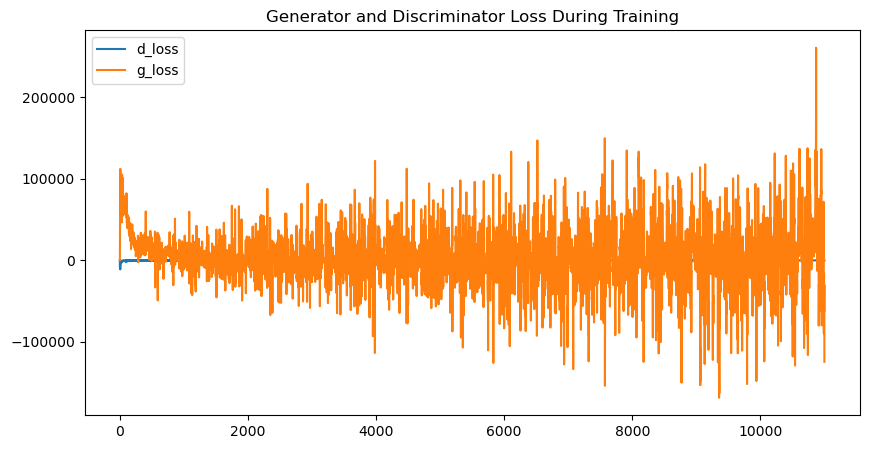

In [16]:
# Plot training history
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_loss_hist, label='d_loss')
plt.plot(g_loss_hist, label='g_loss')
plt.legend()
plt.show()

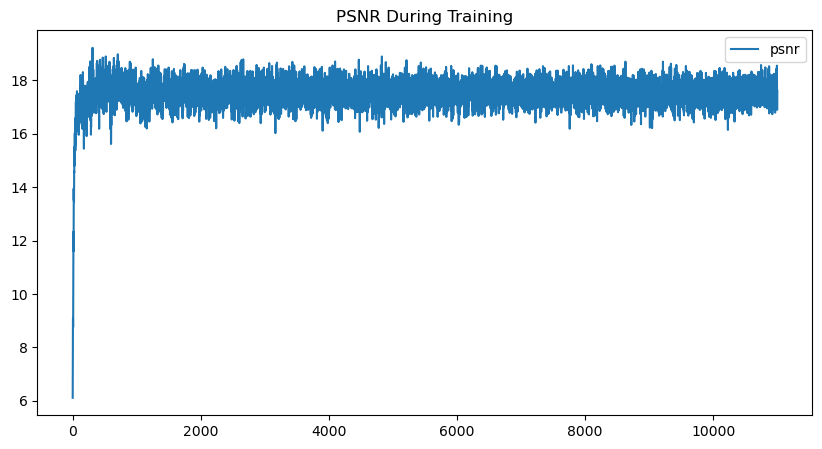

Best PSNR: 19.2210


In [17]:
plt.figure(figsize=(10,5))
plt.title("PSNR During Training")
plt.plot(psnr_hist, label='psnr')
plt.legend()
plt.show()
print(f"Best PSNR: {best_psnr:.4f}")

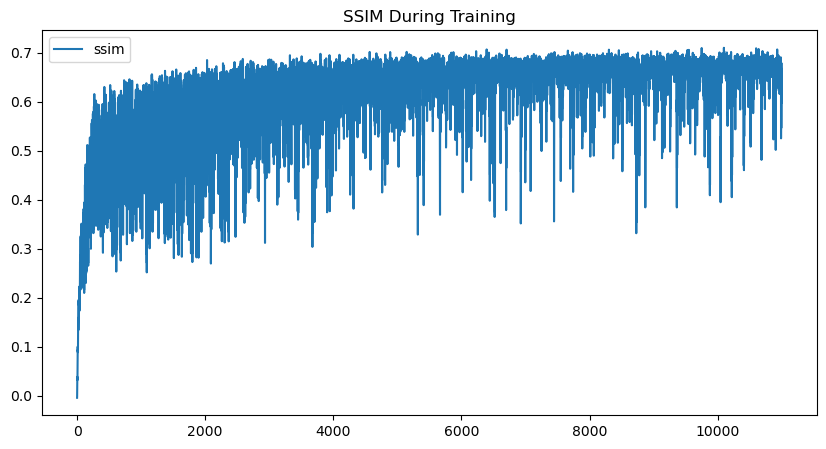

Best SSIM: 0.5949


In [18]:
plt.figure(figsize=(10,5))
plt.title("SSIM During Training")
plt.plot(ssim_hist, label='ssim')
plt.legend()
plt.show()
print(f"Best SSIM: {best_ssim:.4f}")

In [19]:
# fig = plt.figure(figsize=(15,15))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[-50:]]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

In [20]:
# Save models weights
# model dir should be models/wgan_hr_mm_dd_mm
model_dir = "models/wgan_18_35_30_11"
torch.save(best_d_weights, f"{model_dir}/discriminator.pth")
torch.save(best_g_weights, f"{model_dir}/generator.pth")

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2

(-0.5, 529.5, 133.5, -0.5)

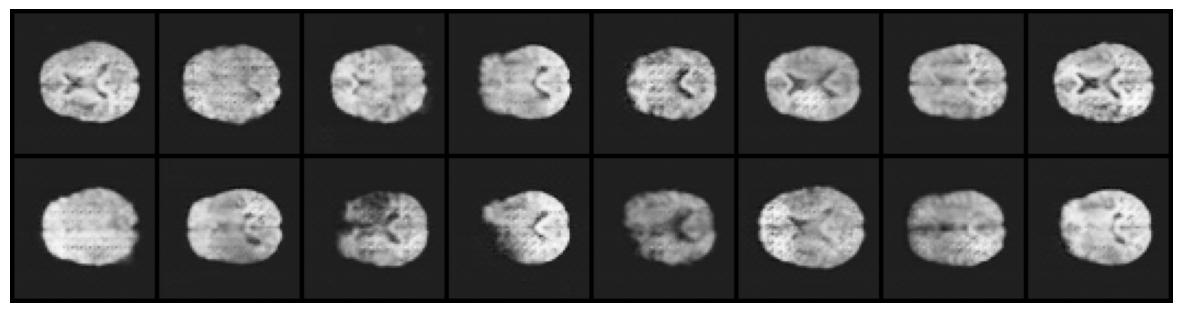

In [21]:
# model dir should be models/dcgan_hr_mm_dd_mm
model_dir = "models/wgan_18_35_30_11"

# Load model and perform inference
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)
print(critic_model)

generator_model = Generator().to(device)
generator_model.apply(weight_init)
print(generator_model)

critic_model.load_state_dict(torch.load(f"{model_dir}/discriminator.pth"))
generator_model.load_state_dict(torch.load(f"{model_dir}/generator.pth"))

generator_model.eval()

fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)

fake = generator_model(fixed_noise).detach().cpu()

plt.figure(figsize=(15, 15))
plt.imshow(
    np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True),
        (1, 2, 0)
    )
)
plt.axis("off")